In [1]:
import statsmodels.stats.multitest as smm
import collections
import json
import random

from rtt_tools import dump_data
from rtt_tools.dump_data import *  # pussy died because of this wildcard import
from rtt_tools.export import *
from rtt_tools.utils import natural_sort_key, default_dict_depth, iterate_flatmap
from rtt_tools.gen.max_rounds import FUNC_DB, FuncDb, FuncInfo

logger = logging.getLogger(__name__)
coloredlogs.CHROOT_FILES = []
coloredlogs.install(level=logging.INFO, use_chroot=False)

In [2]:
js1 = js2 = js = None
funcres = funcres_agg = funrounds = None

In [3]:
js1 = json.load(open('/var/tmp/xklinec/rtt-results-full9.json'))

In [4]:
# js2 = json.load(open('/var/tmp/xklinec/rtt-results-full9-ext01.json'))

In [5]:
#js = js1 + js2
js = js1

In [6]:
#print(json.dumps(js[2829322], indent=2))
#for rix, rec in enumerate(js):
#    if 'lowmc' in rec['data_type']:
#        print(rec['data_type'])
#     exp_info = loader.break_exp_ph4(rec['data_type'])
#     if not exp_info:
#         print('Could not parse %s' % rec['data_type'])
#         continue
#len(js2)

In [7]:
loader = dump_data.Loader()

def exp_info_to_rec(exp_info):
    return collections.OrderedDict([
        ('tp', exp_info.fnc_type),
        ('f', exp_info.fnc_name),
        ('s', exp_info.size),
        ('m', exp_info.meth),
        ('r', exp_info.fnc_round),
        ('e', exp_info.id),
    ])

def name_to_dict(name):  # js[0]['data_type']
    exp_info = loader.break_exp_ph4(name)
    if exp_info is None or exp_info.fnc is None:
        exp_info = loader.break_exp_ph4_mpc(name)
    if exp_info is None or exp_info.fnc is None:
        return None
    return exp_info_to_rec(exp_info)

def parse_test_name(ctest):
    """Dieharder|DAB DCT##[P-sample count][1]##[][] --> ['Dieharder', 'DAB DCT', '1', '']"""
    kcomp = ctest.split("|", 1)
    kcomp = [kcomp[0]] + kcomp[1].split('##')
    kcompr = kcomp[:2]
    for ixx, cxx in enumerate(kcomp[2:]):
        m = krec.match(cxx)
        if not m:
            kcompr.append(cxx)
            continue
        # kcompr.append(m.group(1))
        kcompr.append(m.group(2))
    return kcompr
    
def get_methsize(meth):
    return int(meth.split(':')[-1])

def identity(x):
    return x

def pval_corr(pval):
    """Pvalues close to 1 are often considered as rejecting as well, e.g., AndersonDarling 0.999999999999999"""
    return (1 - pval) if pval is not None and pval != 1 and (1 - pval) < 1e-14 else pval

def test_is_pvalue_close1(test_desc):
    if 'Dieharder' not in test_desc:
        return False
    db = [
        'Diehard Squeeze',
        'RGB Bit Distribution',
        'RGB Lagged Sum',
    ]
    for r in db:
        if r in test_desc:
            return True
    return False

def test_is_strict(test_desc):
    return 'MultinomialBitsOver' not in test_desc

def paper_fname(fname):
    nfname = fname
    nfname = nfname.replace('ROAD-RUNNER-K80', 'R.RUNNER.K80')
    nfname = nfname.replace('ROAD-RUNNER-K128', 'R.RUNNER.K128')
    nfname = nfname.replace('RECTANGLE-K80', 'RECT.K80')
    nfname = nfname.replace('RECTANGLE-K128', 'RECT.K128')
    
    nfname = nfname.replace('testu01-uxorshift', 'U01.XorShift')
    nfname = nfname.replace('testu01-umrg', 'U01.UMRG')
    nfname = nfname.replace('testu01-ulcg', 'U01.ULCG')
    nfname = nfname.replace('std_subtract_with_carry', 'Std.SubCarry')
    nfname = nfname.replace('std_mersenne_twister', 'Std.MTwister')
    nfname = nfname.replace('std_lcg', 'Std.LCG')
    
    nfname = nfname.replace('mimc_hash-', 'MiMC.')
    nfname = nfname.replace('gmimc-', 'GMiMC.')
    nfname = nfname.replace('lowmc-s', 'LowMC.S')
    nfname = nfname.replace('Vision_', 'Vision.')
    nfname = nfname.replace('Starkad_', 'Starkad.')
    nfname = nfname.replace('Rescue_', 'Rescue.')
    nfname = nfname.replace('RescueP_', 'RescueP.')
    nfname = nfname.replace('Poseidon_S128_BLS12_138', 'Poseidon.BLS12')
    nfname = nfname.replace('Poseidon_', 'Poseidon.')
    nfname = nfname.replace('SHA1', 'SHA-1')
    nfname = nfname.replace('SHA2', 'SHA-2')
    nfname = nfname.replace('SHA3', 'SHA-3')
    return nfname

In [8]:
ALPHA_SINGLE = 1e-5
ALPHA_BOOLTEST1 = 1e-5
ALPHA_BOOLTEST2 = 1e-5
ALPHA = 1e-7  # number of alltests executed, avoid false positives in this count

In [9]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

funtype = {}  # fun -> type
funrounds = collections.defaultdict(lambda: set())  # fun -> set of rounds tested
methsize = {}
testvariant = {}
datatype = {}
fnames = set()
test_db = collections.defaultdict(lambda: 0)      # test desc -> test idx
test_db_inv = collections.defaultdict(lambda: 0)  # test idx -> test desc
test_db_ctr = set()
tstart = time.time()

# func_name -> (meth, size) -> round -> test:var:subtest -> [pass, fail, fail]  # 3 seed results
funcres = collections.defaultdict(                   # fncname
    lambda: collections.defaultdict(                 # meth-size
        lambda: collections.defaultdict(             # round
            lambda: collections.defaultdict(         # test-variant-subtest
                lambda: collections.OrderedDict([        
                    ('info', None),
                    ('recidx', None),
                    ('exid', None),
                    ('exs', [None]*3),               # seed-idx -> passed boolean
                    ('exs_info', [None]*3),
])))))

abort_computation = False    
for rix, rec in enumerate(js):
    data_type = rec['data_type']
    if data_type.startswith('PH-SMREF'):
        continue
    #if 'NOEKEON' not in data_type:
    #    continue

    data_type = data_type.replace('stream:cipher', 'stream_cipher')
    exp_info = loader.break_exp_ph4(data_type)
    if exp_info is None or exp_info.fnc is None:
        exp_info = loader.break_exp_ph4_mpc(data_type)
    if not exp_info or not exp_info.fnc:
        print('Could not parse %s' % data_type)
        continue
    if exp_info.fnc_type == 'prng' and rec["exid"] < 339060:  # discard old prng experiments
        continue
    #if rix > 1000:
    #    break
        
    funtype[exp_info.fnc_name] = exp_info.fnc_type
    funrounds[exp_info.fnc_name].add(exp_info.fnc_round)

    meth_size = '%s:%s' % (exp_info.meth, exp_info.size)
    if 'testmpc' in data_type:
        meth_size = '%s:%s:%s' % (exp_info.meth, exp_info.spread, exp_info.size)
    if 't:prng-' in data_type:
        meth_size = '%s:b%s:%s' % (exp_info.meth, exp_info.fnc_block, exp_info.size)
    
    methsize[meth_size] = [exp_info.meth, exp_info.size, exp_info.spread]
    cround = exp_info.fnc_round  # TODO: not always int
    datatype[data_type] = exp_info_to_rec(exp_info)
    
    test_desc = f'{rec["test"]}##[{rec["variant_type"]}][{rec["variant"]}]##[{rec["subtest_type"]}][{rec["subtest"]}]'
    testvariant[test_desc] = collections.OrderedDict([     
        ('test', rec["test"]),   
        ('variant_type', rec["variant_type"]),
        ('variant', rec["variant"]),
        ('variant_id', rec["variant_id"]),
        ('subtest_type', rec["subtest_type"]),
        ('subtest', rec["subtest"]),
        ('exid', rec["exid"]),
    ])
    
    test_db_ctr.add(test_desc)
    fncresrec = funcres[exp_info.fnc_name][meth_size][cround][test_desc]
    fncresrec['exid'] = rec['exid']
    fncresrec['recidx'] = rix
    fncresrec['info'] = data_type
    fncresrec['einfo'] = exp_info

    is_booltest2 = 'booltest_2' in rec["test"]
    is_booltest1 = 'booltest_1' in rec["test"]
    is_pval_bias = test_is_pvalue_close1(rec["test"])
    
    # Iterate over subtests inside a test variant
    nsubs_passed = 0
    pvals = []
    pval_corr_loc = pval_corr if is_pval_bias else identity
    for sub in rec['subs']:
        is_passed = sub['stats'][0]['pass']
        pvalue = sub['stats'][0]['value'] if 'value' in sub['stats'][0] else None

        # Now we check only first statistics from subtest. We may need to aggregate it via pvalue correction (Hollms or min(pvals))
        # e.g., RandomWalk1 has more stats, Chi-square(C), Chi-square(H), Chi-square(J), Chi-square(M), Chi-square(R) 
        # http://simul.iro.umontreal.ca/testu01/guideshorttestu01.pdf page 121
        #
        # On the other hand, some tests return multiple Goodness of fit (GOF) indicators, such as Anderson-Darling, KS D+, KS D-
        # aggregation is more difficult here - use MIN or Hollms correction
        # Also note that pvalues from AD / KS close to 1 are marked as not-passing. 1-pvalue < 1e-14 -> fail (page 89)
        len_stats = len(sub['stats'])
        if len_stats > 1:  # Booltests have single statistics, no need to address here
            is_passed = all(sub['stats'][i]['pass'] for i in range(len_stats))
            pvalue = min(pval_corr_loc(sub['stats'][i]['value']) for i in range(len_stats))
        
        else:
            if not is_booltest1 and not is_booltest2:  # booltest1 returns 1.0 pvalue if not rejected
                pvalue = pval_corr_loc(pvalue)
            elif is_booltest1 and pvalue == 1:
                pvalue = min(1.1*ALPHA_BOOLTEST1 + random.random() * (1 - ALPHA_BOOLTEST1), 1.0)  # pvalue correction for booltest_1, 1.0 is too extreme
            #elif is_booltest1:
            #    pvalue -= 1.1*ALPHA_BOOLTEST1
                
        if pvalue is not None:
            pvals.append(pvalue)
        elif is_booltest2 or is_booltest1:
            print(f'!!! no pval for {data_type}, {test_desc}')
        else:
            print(f'!!! no pval for {data_type}, {test_desc}')
            abort_computation = True

        if is_booltest2:  # Original alpha could have been set differently
            is_passed = pvalue > ALPHA_BOOLTEST2

        # Keeping is_passed from the original classifier, alpha thresholding will be applied later.
        #if not is_booltest1 and pvalue is not None:  # use pvalue-only method for evaluating
        #    is_passed = pvalue > ALPHA_SINGLE
        
        nsubs_passed += int(is_passed)
        if abort_computation: break
        
    nsubs = len(rec['subs'])
    npass_ratio = nsubs_passed / nsubs
    variant_passed = npass_ratio >= 0.99  # tune this ratio! Ratio of passed subtests to consider test passed
    merged_pval = min(pvals) if pvals else None  # merge_pvals, but tree has to be symmetric.
    
    if exp_info.id >= 3:
        print(f'!! Out of range {exp_info.id} for {data_type}')

        # Expand result array if more than 3 results were provided
        [fncresrec['exs'].append(None) for _ in range(exp_info.id + 1 - len(fncresrec['exs']))]
        [fncresrec['exs_info'].append(None) for _ in range(exp_info.id + 1 - len(fncresrec['exs_info']))]
        
    fncresrec['exs'][exp_info.id] = variant_passed
    fncresrec['exs_info'][exp_info.id] = collections.OrderedDict([
        ('exid', rec['exid']),
        ('recidx', rix),
        ('info', data_type),
        ('einfo', exp_info),
        ('nsubs', nsubs),
        ('nsubsp', nsubs_passed),
        ('nsubsr', npass_ratio),
        ('mpval', merged_pval),
    ])

    if len(pvals) > 1:
        fncresrec['exs_info'][exp_info.id]['pvals'] = pvals
    if abort_computation: break
    # print('#: %s, pass: %s, pct: %2.7f' % (nsubs, nsubs_passed, 100*nsubs_passed/nsubs))
    
# Reindex tests so we have stable IDs
all_tests = sorted(list(test_db_ctr))
for ix, test in enumerate(all_tests):
    test_db[test] = ix
    test_db_inv[ix] = test
    
ftime = time.time() - tstart
print(f'Proc1 done in {ftime} s = {"%.2f" % (ftime/60)} m')

/tmp/ipykernel_1433345/3497921037.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


Proc1 done in 1251.6486039161682 s = 20.86 m


In [17]:
js = js1 = js2 = None
#list(funcres['DynamicSHA']['hw:10485760'][12]['Dieharder|STS Runs Test##[P-sample count][24]##[][]']['exs_info'])

In [11]:
# Recompute pass criteria
for fname, methsize, rnd, testsdesc, fncresrec in iterate_flatmap(funcres, 4):
    print(f'{fname}, {methsize}, {rnd}, desc: {testsdesc}, rec: {fncresrec}')
    break
    
    is_booltest2 = 'booltest_2' in testsdesc
    if not is_booltest2:
        continue
    
    num_exids = len(fncresrec['exs'])
    for exp_info_id in range(num_exids):
        if fncresrec['exs'][exp_info_id] is None:
            continue

        nsubs_passed = 0
        pvals = fncresrec['exs_info'][exp_info_id]['pvals']
        fncresrec['exs'][exp_info_id] = variant_passed

Poseidon_S80b, lhw:s15mb:104857600, 1-0-0, desc: TestU01 Alphabit|smultin_MultinomialBitsOver##[Bit NB|Bit R|Bit S|Repetitions][100000000|0|32|1]##[L|N|Sparse|n|r|s][2|1|FALSE|100000000|0|32], rec: OrderedDict([('info', 'starkad_poseidon-testmpc60-Poseidon_S80b-pri-raw-r1-0-0-inp-lhw02-b20-w5-spr-s15mb-s100MB'), ('recidx', 9968903), ('exid', 354999), ('exs', [True, True, True]), ('exs_info', [OrderedDict([('exid', 354997), ('recidx', 9175669), ('info', 'starkad_poseidon-testmpc60-Poseidon_S80b-pri-raw-r1-0-0-inp-lhw00-b20-w5-spr-s15mb-s100MB'), ('einfo', Einfo(id=0, m='lhw', s=None, si=104857600, osi=104857600, fname='Poseidon_S80b', fr='1-0-0', fb=20, spr='s15mb', otype='pri')), ('nsubs', 1), ('nsubsp', 1), ('nsubsr', 1.0), ('mpval', 0.7400000095367432)]), OrderedDict([('exid', 354998), ('recidx', 9142273), ('info', 'starkad_poseidon-testmpc60-Poseidon_S80b-pri-raw-r1-0-0-inp-lhw01-b20-w5-spr-s15mb-s100MB'), ('einfo', Einfo(id=1, m='lhw', s=None, si=104857600, osi=104857600, fname='Po

In [12]:
# funcres["AES"]["ctr:10485760"][3]
# Analyze function -> meth-size -> round; all tests, reject if 2/3 rejected
tstart = time.time()

# All experiments computed
data_type_set = set()

# func_name -> (meth, size) -> round -> {summary dict}
funcres_agg = collections.defaultdict(               # fncname
    lambda: collections.defaultdict(                 # meth-size
        lambda: collections.defaultdict(             # round        
            lambda: collections.OrderedDict([        
                ('num_tests', 0),
                ('num_rej', 0),
                ('rejects', False),
                ('lib_num_tests', 0),
                ('lib_num_rej', 0),
                ('lib_rejects', False),
                ('info', None),
                ('einfo', None),
                ('exid', None),
                ('exs_info', collections.defaultdict(lambda: collections.OrderedDict([
                    ('exids', set()),
                    ('num_tests', 0),
                    ('num_rej', 0),
                    ('lib_rejects', 0),
                    ('rejs', set()),
                    ('lib_rejs', set()),
                    ('all_tests', set()),
                    ('min_pval', 1.0),
                    ('all_pvals', []),  # booltest1 not included
                    ('bt1_pvals', []),  # booltest1 pvalues only
                    ('num_rej_bt1', 0),
                    ('num_rej_st', 0),  # strict set of tests
                    ('num_all_st', 0),  # strict set of tests
                ]))),
])))) 

# Liberal thresholding - both of the above
liberal_threshold_ratio = 0.011  # at least 0.011 rejection rate
liberal_threshold_const = 3  # at least 3 tests
conservative_ratio = 0.01  # num_rej / num_tests; num_rej += 1 if the same tests was rejected at least twice; # TUNE THIS!

ignore_random_excursions = True
ignore_testmpc = False

uncomps = 0
uncomps_funcs = collections.Counter()
uncomps_set = set()
uncomps_bat = set()
rerun_cmds = collections.defaultdict(lambda: set())
nonames_set = set()
rerun_tests = collections.defaultdict(lambda: collections.defaultdict(lambda: None))  # ename -> test -> aux data
ctr_all_tests = 0
ctr_all_seeds = 0
ctr_meth_sizes = collections.Counter()

bat_map = {
    'NIST Statistical Testing Suite': '--nist_sts',
    'Dieharder': '--dieharder',
    'TestU01 Alphabit': '--tu01_alphabit',
    'TestU01 Small Crush': '--tu01_crush',
    'TestU01 Rabbit': '--tu01_rabbit',
    'TestU01 Block Alphabit': '--tu01_blockalphabit',
    'TestU01 Crush': '--tu01_crush',
    'booltest_1': '--booltest-1',
    'booltest_2': '--booltest-2',
}

expfiles = []
expfiles_path = '../ph4-01/exps-dump/__expfiles.json'
if os.path.exists(expfiles_path):
    with open(expfiles_path) as fh:
        expfiles = json.load(fh)
        
        
def find_expfile(tpl, expfiles):
    for fname in expfiles:
        if tpl in fname:
            yield fname

num_corrections = 0
abort_computation = False     
abort_ctr = 0      
fh_proclog_a = open('proclog_a.txt', 'w+')  
fh_proclog_b = open('proclog_b.txt', 'w+')  
for fname in funcres:
    #if 'NOEKEON' not in fname: continue
    for meth_size in funcres[fname]:
        #if 'ctr:10485760' not in meth_size: continue
        for cround in funcres[fname][meth_size]:
            ctests = funcres[fname][meth_size][cround]  # all tests map
            crec = funcres_agg[fname][meth_size][cround]  # resulting dict
            ctr_all_seeds += 3  # 3 seeds per configuration
            ctr_meth_sizes[int(meth_size.split(':')[-1])] += 1

            for ctest in ctests:
                data_type_set.add(ctests[ctest]["info"])
                
                # Iterate over all different seed experiments
                # Computes just aux info - summarizes uncomputed experiments, fixes ename
                for resix, resex in enumerate(ctests[ctest]['exs']):
                    ctr_all_tests += 1
                    if resex is None:
                        uncomps += 1
                        uncomps_funcs[fname] += 1
                        ename = ctests[ctest]["info"]
                        
                        if ignore_random_excursions and 'Random Excursions' in ctest:
                            continue
                        if ignore_testmpc and 'testmpc' in ename:
                            continue
                            
                        if '-e:' in ename:
                            ename2 = re.sub(r'-e:[\d]-', f'-e:{resix}-', ename)  # get seed run we need
                            ename2 = re.sub(r'-i:([\w]+(:?\.key)?)-.*', '-i:\\1', ename2)  # cut off input specifications
                            ename2 = re.sub(r'^PH4-SM-[\d]+-', '', ename2)  # remove testing prefix, anything goes
                            fnames = list(find_expfile('-' + ename2.replace(':', '_'), expfiles))
                            if len(fnames) == 0:
                                # print(f'! no fnames found. Cfg: {fname} {meth_size} {cround} {ctest} | ename: {ename} | resix: {resix}. (Check expfiles.json)')
                                nonames_set.add(ename)
                                
                            if len(fnames) != 1:
                                # print(f'- more fnames than 1 ({len(fnames)}): {fnames}, Cfg: {fname} {meth_size} {cround} {ctest} | ename: {ename} | resix: {resix}')
                                fnames.sort(key=natural_sort_key)
                                fnames = list(reversed(fnames))
                                
                            ename = fnames[0] if fnames else ename
                            ename = ename.replace('.json', '')
                            ename = ename.replace('_', ':')
                            ename = ename.replace('stream:cipher', 'stream_cipher')

                        elif 'testmpc' in ename:
                            ename = re.sub(r'-inp-([\w]+?)([\d]+)-', '-inp-\\1!XXXX', ename)
                            ename = ename.replace('!XXXX', '%02d-' % resix)
                            ename = ename.replace('.json', '')
                            ename = re.sub(r'^.*-testmpc', 'testmpc', ename)
                        
                        uncomps_set.add(ename)
                        uncomps_bat.add(ctest.split('|')[0])
                        rerun_cmds[ename].add(ctest.split('|')[0])
                        rerun_tests[ename][ctest] = (cround, ctests[ctest]["exs"], ctests[ctest]["recidx"], ctests[ctest]["info"])
                        # print(f'Uncomputed: {fname}-{meth_size}-{cround}-{ctest}-{ctests[ctest]["exs"]}-{ctests[ctest]["recidx"]}, ename: {ename}, orig: {ctests[ctest]["info"]}')
                    
                if None in ctests[ctest]['exs']:                    
                    # print(json.dumps(js[ctests[ctest]["recidx"]], indent=2))
                    continue

                #is_test_close1 = test_is_pvalue_close1(ctest)
                is_test_strict = test_is_strict(ctest)
                is_booltest1 = 'booltest_1' in ctest
                    
                # Liberal interpretation: threshold of tests is enough to tell that we reject the generator.
                # Iterating over seed variant runs for given fname-methsize-round-ctest
                exs_info = ctests[ctest]['exs_info']
                for ix, exsinfo in enumerate(exs_info):
                    if exsinfo is None:
                        continue  # test was not found for this exp.id (seed alternation)
                        
                    # Single test rejects single seed stream
                    # is_rejected = int(not ctests[ctest]['exs'][ix]) if ctests[ctest]['exs'][ix] is not None else 0 
                    is_rejected = 0
                    c_pval = exs_info[ix]['mpval']
                    if c_pval is not None:
                        if is_booltest1:
                            is_rejected = c_pval < ALPHA_BOOLTEST1
                        else:
                            is_rejected = c_pval < ALPHA_SINGLE

                    ecrec = crec['exs_info'][ix]  # ecrec ~ funcres_agg[fname][meth_size][cround]['exs_info'][ix]
                    ecrec['exids'].add(exs_info[ix]['exid'])
                    ecrec['num_tests'] += 1
                    ecrec['num_rej'] += is_rejected
                    ecrec['all_tests'].add(test_db[ctest])
                    if ecrec['min_pval'] is None:
                        ecrec['min_pval'] = c_pval
                    if c_pval is not None:
                        ecrec['min_pval'] = min(ecrec['min_pval'], c_pval) 
                        if is_booltest1:
                            ecrec['bt1_pvals'].append(c_pval)
                        else:
                            ecrec['all_pvals'].append(c_pval)
                    if is_test_strict:
                        ecrec['num_all_st'] += 1
                    if is_rejected:
                        ecrec['rejs'].add(test_db[ctest])
                    
                        # Booltest1 fixed-alpha failing criter
                        if 'booltest_1' in ctest:
                            ecrec['num_rej_bt1'] += 1
                        if is_test_strict:
                            ecrec['num_rej_st'] += 1
                        
                    # With each update recompute lib_rejects criteria based on the current test results.    
                    ecrec['lib_rejects'] = ecrec['num_rej'] >= liberal_threshold_const and (ecrec['num_rej'] / ecrec['num_tests']) >= liberal_threshold_ratio
                    ecrec['corr_rejects'] = ecrec['lib_rejects']
                    if ecrec['lib_rejects']:
                        ecrec['lib_rejs'].add(test_db[ctest])
        
                    # Global liberal view, summarizing seed runs
                    crec['lib_num_tests'] += 1
                    crec['lib_num_rej'] += is_rejected

                # Conservative interpretation: We reject if we can reproduce the *same test* at least 2 times. 
                # 'num_rej' is then number of tests that rejected the same input at least 2 times. 
                is_rejected = sum(ctests[ctest]['exs']) <= 1  # counting passes, 1 or less passes -> rejected (2+ rejections)
                crec['num_tests'] += 1  # +1 for each test computed for fnc-methsize-round
                crec['num_rej'] += int(is_rejected)  # +1 for each rejection by a single test for fnc-methsize-round, reproduced on 2+ buckets
                crec['info'] = ctests[ctest]['info']
                crec['einfo'] = ctests[ctest]['einfo']
                crec['exid'] = ctests[ctest]['exid']

            # All tests processed atm. 
            if crec['num_tests'] == 0:
                print(f'! zero tests: f:{fname} m:{meth_size} r:{cround}')
                continue

            cratio = crec['num_rej'] / crec['num_tests']
            crec['rejects'] = cratio >= conservative_ratio
            crec['lib_rejects'] = sum([int(crec['exs_info'][kk]['lib_rejects']) for kk in crec['exs_info'].keys()]) > 1  # 2 or more rejects
            crec['min_pval'] = min([crec['exs_info'][kk]['min_pval'] for kk in crec['exs_info'].keys()])

            # 2nd pass of evaluation for failure - using pvalues and Hommel corrections
            # for gray-zone area. Works as a classifier.
            was_corrected_1plus = False
            for ix, exsinfo in enumerate(crec['exs_info']):
                if exsinfo is None:
                    continue  

                ecrec = crec['exs_info'][ix]  # ecrec ~ funcres_agg[fname][meth_size][cround]['exs_info'][ix]
                ecrec['lib_rejects_corr'] = ecrec['lib_rejects']
                fail_r = ecrec['num_rej'] / ecrec['num_tests']
                if ecrec['num_rej'] < 1 or fail_r >= 0.2:  # ignore hard fails and hard accepts
                    continue
                if not ecrec['all_pvals']:
                    continue
                
                num_corrections += 1
                smres = smm.multipletests(ecrec['all_pvals'], alpha=ALPHA, method='hommel')
                is_loc_rej = any(smres[0])
                ecrec['corr_rejects'] = is_loc_rej
                ecrec['corr_pvals'] = [x for x in smres[1] if x <= ALPHA]

                # Booltest1 simult test failing method
                # Number of simult failing bt1 test when failing with a fixed alpha 1e-5, but simult failures aggregate
                is_loc_btrej = False
                if ecrec['num_rej_bt1'] >= 3:
                    is_loc_btrej = is_loc_rej = True

                # Num of strict test fails method
                # number of simult failing tests, simult failures aggregate
                is_loc_num_rej = False
                if ecrec['num_rej_st'] >= 8:
                    is_loc_num_rej = is_loc_rej = True

                ecrec['lib_rejects_corr'] = is_loc_rej
                was_corrected = ecrec['lib_rejects'] != is_loc_rej
                was_corrected_1plus |= was_corrected

                if True or ('FANTOMAS' in fname and cround == 3):
                    ss = (f'::->{"C" if was_corrected else " "} | {fname} {meth_size} {cround} [{ix}] exid {ecrec["exids"]}, num pvals: {len(ecrec["all_pvals"])}, loc rej: {is_loc_rej}, lib rej: {ecrec["lib_rejects"]}, bt1 rej: {is_loc_btrej}, strict rej: {is_loc_num_rej}' )   
                    fh_proclog_a.write(ss + "\n")
                    #print(ecrec["all_pvals"])

                if abort_computation or abort_ctr > 100: break
                #abort_computation = True
                #abort_ctr += 1

            if was_corrected_1plus:
                crec['lib_rejects'] = sum([int(crec['exs_info'][kk]['lib_rejects_corr']) for kk in crec['exs_info'].keys()]) > 1  # 2 or more rejects
                fh_proclog_b.write(f'--- rec: {crec}\n')
                #if 'FANTOMAS' in fname and cround == 3:
                #    print(f'--- rec: {crec}')

            if abort_computation or abort_ctr > 100: break
        if abort_computation or abort_ctr > 100: break
    if abort_computation or abort_ctr > 100: break

fh_proclog_a.close()
fh_proclog_b.close()
print(f'Meth sizes processed: {ctr_meth_sizes}')
print('Proc2 done in %s s, num corrs: %s, ctr seeds: %s, ctr tests: %s' % (time.time() - tstart, num_corrections, ctr_all_seeds, ctr_all_tests))

! zero tests: f:lowmc-s128a m:lhw::1073741824 r:5
! zero tests: f:lowmc-s80a m:lhw::1073741824 r:5
! zero tests: f:lowmc-s80b m:lhw::1073741824 r:5
! zero tests: f:Vision_S45a m:lhw:s18ob:1073741824 r:1
! zero tests: f:Vision_S45a m:ctr:s18ob:1073741824 r:1
! zero tests: f:Vision_S45a m:ctr:s0mb:1073741824 r:1
! zero tests: f:Vision_S128d m:sac:s0mb:104857600 r:2
! zero tests: f:Vision_S128d m:ctr:s18ab:1073741824 r:1
! zero tests: f:Vision_S128d m:lhw:s18ob:1073741824 r:1
! zero tests: f:Vision_S128d m:ctr:s0mb:1073741824 r:1
! zero tests: f:Vision_S128d m:ctr:s18ob:1073741824 r:1
! zero tests: f:Vision_S128d m:lhw:s0mb:1073741824 r:1
! zero tests: f:XTEA m:sac.key..ornd.inp:10485760 r:3
! zero tests: f:DynamicSHA m:sac:1048576000 r:9
Meth sizes processed: Counter({104857600: 6558, 10485760: 6294, 1048576000: 4496, 1073741824: 134})
Proc2 done in 231.82614183425903 s, num corrs: 5620, ctr seeds: 52446, ctr tests: 13078770


In [13]:
print('* Unrun Experiments:')
kspaces = [20, 38, 20, 20, 20, 20, 20]
krec = re.compile(r'^\[(.*?)\]\s*\[(.*?)\]$')

for ename in []:  # sorted(list(rerun_tests.keys())):
    recs = sorted(list(rerun_tests[ename].keys()))
    print(f'\n{ename}')
    for k in recs:
        rec = rerun_tests[ename][k]
        kcomp = k.split("|", 1)
        kcomp = [kcomp[0]] + kcomp[1].split('##')
        kcompr = kcomp[:2]
        for ixx, cxx in enumerate(kcomp[2:]):
            m = krec.match(cxx)
            if not m:
                kcompr.append(cxx)
                continue
            kcompr.append(m.group(1))
            kcompr.append(m.group(2))
            
        kform = ' | '.join([x.ljust(kspaces[ix] if ix < len(kspaces) else 20) for ix, x in enumerate(kcompr)])
        print(f'  {"%21s" % rec[1]} | {kform} | {rec[2]} {rec[3]}')
    #raise ValueError()
            
print('\n\n\n\n\n\n\n--------------------\nUncomputed total:', uncomps, 'functions:', uncomps_funcs, ' batteries:', uncomps_bat)
for ename in sorted(list(rerun_cmds.keys())):
    fname = ename.replace(':', '_')
    fname += '.json'
    bats = sorted(list(rerun_cmds[ename]))
    ename2 = ename.replace('-SM-01-', '-SM-04-')
    ename2 = ename2.replace('-SM-02-', '-SM-04-')
    fsize = ('100' if '100MiB' in fname else '10') if 'MiB' in fname else ('100' if '100MB' in fname else '10')
    print(f"submit_experiment {' '.join([bat_map[x] for x in bats])} --name '{ename2}' --cfg '/home/debian/rtt-home/RTTWebInterface/media/predefined_configurations/{fsize}MB.json' --cryptostreams-config '{fname}'")
    
print('\n\n\n-------------------Resubmit summary:')
for ename in sorted(list(rerun_cmds.keys())):
    bats = sorted(list(rerun_cmds[ename]))
    fsize = ('100' if '100MiB' in fname else '10') if 'MiB' in fname else ('100' if '100MB' in fname else '10')
    print(f"{ename} : {' '.join([bat_map[x] for x in bats])} @ {fsize}MB")

print('\n\n\n-------------------No names sum:')
for x in sorted(list(nonames_set)):
    print(x)
    
print('-----------------\n\n\nProc2 done') 
print('Num of computed experiments: %s' % (len(data_type_set)))


* Unrun Experiments:







--------------------
Uncomputed total: 8128 functions: Counter({'Vision_S128d': 1521, 'Vision_S45a': 1484, 'DynamicSHA': 1217, 'lowmc-s128a': 646, 'lowmc-s80a': 646, 'lowmc-s80b': 646, 'XTEA': 450, 'TRIPLE-DES': 141, 'SINGLE-DES': 136, 'BLOWFISH': 132, 'Grain': 100, 'mimc_hash-S80': 54, 'mimc_hash-S45': 49, 'LED': 49, 'lowmc-s128d': 48, 'lowmc-s128c': 48, 'lowmc-s128b': 48, 'Rescue_S45a': 48, 'LBLOCK': 36, 'gmimc-S45a': 31, 'JH': 29, 'AES': 28, 'DECIM': 27, 'TEA': 26, 'CHASKEY': 22, 'RECTANGLE-K128': 22, 'PICCOLO': 20, 'SHACAL2': 18, 'SERPENT': 18, 'KASUMI': 18, 'Salsa20': 18, 'SPECK': 17, 'RIPEMD160': 16, 'ROBIN-STAR': 16, 'SEED': 13, 'RECTANGLE-K80': 12, 'LEA': 12, 'Starkad_S80b': 11, 'FANTOMAS': 11, 'ROBIN': 11, 'LEX': 10, 'ROAD-RUNNER-K80': 10, 'GOST': 10, 'std_lcg': 10, 'Tiger': 9, 'ARIRANG': 8, 'DynamicSHA2': 8, 'Chacha': 8, 'RC6': 8, 'PRIDE': 8, 'RC5-20': 8, 'PRINCE': 8, 'Skein': 8, 'Hermes': 8, 'MD6': 8, 'Lesamnta': 7, 'F-FCSR': 7, 'mimc_hash-S128': 

In [13]:
# sync ftable.txt and process
# rsync -av 'aura:~/RTT/{ftable.txt,proclog_a.txt,proclog_b.txt}' . ; grep 'H::' ftable.txt > ftable-hash.txt ; grep 'B:S:' ftable.txt > ftable-stream.txt ; grep 'P::' ftable.txt > ftable-prng.txt ; grep 'B:B:' ftable.txt > ftable-block.txt ; grep 'B:M:' ftable.txt > ftable-mpc.txt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Liberal thresholding
# TODO: compute higher rounds for liberal interpretation, e.g., Tangle has not enough
use_liberal = True
funcs_no_rounds = set(['MCSSHA3', 'Shabal'])

log_lines = []
table_lines = []
tests_to_print = set()

exids_recomp_margin = 5  # rounds a top of maximal / the latest fail; only 10 & 100 MB (faster)
exids_recompute = collections.defaultdict(  # fname
    lambda: collections.defaultdict(        # meth:size
        lambda: [[],[]]))                   # set of rounds to compute

exids_recomp_margin_1000MB = 1  # rounds a top of maximal / the latest fail
exids_recompute_1000MB = collections.defaultdict(  # fname
    lambda: collections.defaultdict(        # meth:size
        lambda: None))                      # set of rounds to compute

exids_computed_1000MB = collections.defaultdict(  # fname
    lambda: collections.defaultdict(              # meth:size
        lambda: 0))

compute_cols = collections.defaultdict(     # ftype:fname
    lambda: collections.defaultdict(        # meth:size
        lambda: list()))                    # set of rounds to compute

computed_cols = collections.defaultdict(     # ftype:fname
    lambda: collections.defaultdict(         # meth:size
        lambda: set()))                      # set of rounds to compute 

##
#stat_continuous_rounds = default_dict_depth(2, lambda: 0)      # ftype:fname -> meth
stat_sizes = default_dict_depth(3, lambda: 0)                   # ftype:fname -> meth_nosize -> size -> round; max broken round, outliers included
stat_broken_rnds = default_dict_depth(2, lambda: None)          # ftype:fname -> meth -> round; max broken round, outliers included
stat_broken_rnds_cont = default_dict_depth(2, lambda: None)     # ftype:fname -> meth -> round; max broken round, without outliers
stat_rej_rounds_segments = default_dict_depth(2, lambda: None)  # ftype:fname -> meth -> segments; rejection segments, list of consecutively broken rounds
stat_rej_rgaps = default_dict_depth(2, lambda: 0)               # ftype:fname -> meth -> gap size between last 2 segments
stat_all_tests = default_dict_depth(3, lambda: list())          # ftype:fname -> meth -> round -> [testidx]; list of all tests
stat_rej_tests = default_dict_depth(3, lambda: list())          # ftype:fname -> meth -> round -> [testidx]; list of rejecting tests on all rounds; union
stat_rej_tests_rep = default_dict_depth(3, lambda: list())      # ftype:fname -> meth -> round -> [(testidx, repcnt)];  tests that were repeated at least once in seedrun. Order by counter
stat_rej_tests_seg = default_dict_depth(3, lambda: list())      # ftype:fname -> meth -> round -> [testidx]; list of rejecting tests on last segment round
stat_rej_tests_rep_seg = default_dict_depth(3, lambda: list())  # ftype:fname -> meth -> round -> [(testidx, repcnt)], tests that were repeated at least once in seedrun. Order by counter
stat_rej_ratio = default_dict_depth(3, lambda: 0.0)             # ftype:fname -> meth -> round -> rejection ratio rej_tests/all_tests. Strength of rejection
stat_rej_ratio_st = default_dict_depth(3, lambda: 0.0)          # ftype:fname -> meth -> round -> rejection ratio rej_tests/all_tests. Strength of rejection, strict tests
##

for fname in sorted(funcres_agg.keys(), key=natural_sort_key):
    fname_low = fname.lower()
    
    # Find info per-fname
    fmeth = list(funcres_agg[fname].keys())
    fround = list(funcres_agg[fname][fmeth[0]].keys()) if fmeth else None
    finfo = funcres_agg[fname][fmeth[0]][fround[0]] if fround else None
    finfo = finfo['einfo'] if finfo and 'einfo' in finfo else None
        
    erec = FUNC_DB.search(fname, FuncInfo.HASH if finfo is not None and finfo.fnc_type == 'hash' else FuncInfo.CIPHER)
    if erec is None and finfo.fnc_type == 'prng':
        erec = FuncInfo(fname, FuncInfo.PRNG, 0, 1, 1)
    
    max_rounds_cur = erec.max_rounds if erec else None
    crypt_rounds_cur = erec.human_broken_rounds if erec else None
    max_rounds_cur_s = ('%3d' % max_rounds_cur) if max_rounds_cur is not None else ' - '
    crypt_rounds_cur_s = ('%3d' % crypt_rounds_cur) if crypt_rounds_cur is not None else ' - '
    max_rnd_broken = None
    max_rnd_broken_100 = None
    max_rnd_broken_meth = collections.defaultdict(lambda: 0)
    max_rnd_broken_meth_100 = collections.defaultdict(lambda: 0)
    min_rnd_meth = collections.defaultdict(lambda: 999)
    max_rnd_meth = collections.defaultdict(lambda: 0)
    comp_rounds_meth = collections.defaultdict(lambda: list())
    ftypename = f'{erec.ftype}:{fname}'
    is_stream_cipher = erec.stype == FuncInfo.STREAM and erec.ftype == FuncInfo.CIPHER
    fname_lbl = f'{"H" if erec.ftype == FuncInfo.HASH else ("P" if erec.ftype == FuncInfo.PRNG else "B")}:' \
                f'{"M" if erec.stype == FuncInfo.MPC else ("S" if erec.stype == FuncInfo.STREAM else ("B" if erec.ftype == FuncInfo.CIPHER else ""))}:{fname}'
    
    for meth in sorted(funcres_agg[fname].keys()):
        meth_parts = meth.split(':')
        is_col_type = '.key' in meth

        # Skip input stream for stream ciphers as it does not make much sense
        if is_stream_cipher and (not is_col_type and not meth_parts[0] == 'zero'):
            continue

        namemeth = funcres_agg[fname][meth]
        #if '104857600' not in meth: # or 'sac:' in meth:
        #    continue
        
        h100MB = 104857600
        h1000MB = 1048576000
        
        meth_size = int(meth_parts[-1])
        meth_nosize = ':'.join(meth_parts[:-1])
        is_below_1000 = meth_size < h1000MB
        
        rounds = list(namemeth.keys())
        for ix, rnd in enumerate(rounds):
            if rnd == '1-0-0':
                rounds[ix] = 1
                namemeth[1] = namemeth['1-0-0']
            if rnd == '2-0-0':
                rounds[ix] = 2
                namemeth[1] = namemeth['2-0-0']
            if rnd == '3-0-0':
                rounds[ix] = 3
                namemeth[1] = namemeth['3-0-0']    
            if rnd == 'x':
                namemeth[1] = namemeth['x']
                rounds[ix] = 1
            if rnd is None:
                namemeth[1] = namemeth[None]
                rounds[ix] = 1
           
        rounds.sort()
        cexids = [-1]*3
        min_rnd_meth[meth] = rounds[0]
        max_rnd_meth[meth] = rounds[-1]
        comp_rounds_meth[meth] = rounds
        cur_comp_rounds = set(rounds)

        # Eval stats helpers
        is_continuous_break = None
        rej_rounds_segments = [[]]  # segments of continuously rejected rounds
        round_comp_gaps = []  # all rounds that are missing from the computation

        for rndix, rnd in enumerate(rounds):
            crec = namemeth[rnd]
            cexid = crec['exid']
            cur_exids = [None] * 3

            all_run_tests = set()  # for stat_all_tests
            all_run_tests_st = 0
            cset_rejected_tests = set()
            cctr_rejected_tests = collections.Counter()
            cctr_rejected_tests_st = 0
            for ixx in crec['exs_info'].keys():
                # Collect experiment IDs
                ttcur = crec['exs_info'][ixx]['exids']
                cur_exids[ixx] = max(ttcur) if ttcur else None
                cexids[ixx] = max(cexids[ixx], max(ttcur))

                # Collect run and rejecting tests
                all_run_tests = all_run_tests.union(crec['exs_info'][ixx]['all_tests'])
                all_run_tests_st += crec['exs_info'][ixx]['num_all_st']
                cctr_rejected_tests_st += crec['exs_info'][ixx]['num_rej_st']

                # Voting 2 repetitions or all detections
                # Tests that repeated at least once
                crejs = crec['exs_info'][ixx]['lib_rejs'].union(crec['exs_info'][ixx]['rejs'])
                cset_rejected_tests = cset_rejected_tests.union(crejs)
                for ii in crejs:
                    cctr_rejected_tests[ii] += 1
                del (crejs,)
            
            stat_rej_tests_rep[fname_lbl][meth][rnd] = dict(cctr_rejected_tests)
            stat_rej_tests[fname_lbl][meth][rnd] = list(cset_rejected_tests)
            del (cset_rejected_tests, cctr_rejected_tests)
            
            stat_all_tests[fname_lbl][meth][rnd] = all_run_tests
            stat_rej_ratio[fname_lbl][meth][rnd] = float(len(stat_rej_tests[fname_lbl][meth][rnd])) / len(all_run_tests) if all_run_tests else None
            stat_rej_ratio_st[fname_lbl][meth][rnd] = float(cctr_rejected_tests_st) / all_run_tests_st if all_run_tests_st > 0 else None
            del (all_run_tests, )

            cur_rejects = crec['lib_rejects'] if use_liberal else crec['rejects']
            cnum_rej = crec["lib_num_rej"] if use_liberal else crec["num_rej"]
            cnum_tests = crec["lib_num_tests"] if use_liberal else crec["num_tests"]
            
            con_rejects = crec['rejects']
            con_num_rej = crec["num_rej"]
            con_num_tests = crec["num_tests"]

            # Evaluation statistics
            if cur_rejects and is_continuous_break is None:
                is_continuous_break = True
            if not cur_rejects and is_continuous_break is not None:
                is_continuous_break = False

            if cur_rejects and len(rej_rounds_segments[0]) > 0 and rej_rounds_segments[-1][-1] + 1 < rnd:
                rej_rounds_segments.append([rnd])
            elif cur_rejects:
                rej_rounds_segments[-1].append(rnd)

            if rndix > 0 and rounds[rndix-1] != rnd+1:
                round_comp_gaps += [i for i in range(rounds[rndix-1], rnd)]

            # Conservative view on rejection - same test fails at least twice on 3 seed streams
            # Liberal: X tests per seed run. Needs to be set properly.
            if cur_rejects and (max_rnd_broken is None or rnd > max_rnd_broken):
                max_rnd_broken = rnd
                
            if cur_rejects and is_below_1000 and (max_rnd_broken_100 is None or rnd > max_rnd_broken_100):
                max_rnd_broken_100 = rnd
                    
            if cur_rejects and (max_rnd_broken_meth[meth] is None or rnd > max_rnd_broken_meth[meth]):
                max_rnd_broken_meth[meth] = rnd
            
            if cur_rejects and is_below_1000 and (max_rnd_broken_meth_100[meth] is None or rnd > max_rnd_broken_meth_100[meth]):
                max_rnd_broken_meth_100[meth] = rnd
            
            if is_col_type and is_below_1000:
                computed_cols[ftypename][meth].add(rnd)
                
            # Detailed view on which tests failed in which experiments
            # In conservative interpretation, we require the same test to fail at least twice / 3 runs.
            # 'num_rej' thus does not have to match rejected tests in particular seed run 
            # (e.g., if test IDs are disjunct, 'num_rej' is 0)
            # min_pval = crec['min_pval'] if 'min_pval' in crec else None
            min_pvals = '[' + ', '.join([("%.3e" % crec['exs_info'][kk]['min_pval'] if 'min_pval' in crec['exs_info'][kk] else '-') for kk in crec['exs_info'].keys()]) + ']'
            rejs_details = f"exs: {', '.join(map(str, cur_exids))}, mpv: {min_pvals}"
            if cnum_rej < 15:  # disabled for brevity
                rejs_details_l = []
                for kix in crec['exs_info'].keys():
                    exs_info2 = crec['exs_info'][kix]
                    rejs_details_l.append(sorted(list(exs_info2['rejs'])))
                rejs_details += ", [" + "; ".join([", ".join(['%3d' % y for y in x]) for x in rejs_details_l]) + "]"
            
            det_seeds = ''.join([str(int(crec['exs_info'][kk]['lib_rejects_corr'])) for kk in crec['exs_info'].keys()])  # detected seeds bit map
            conv_str = ''
            if use_liberal:
                conv_str = '; c %s (%3d/%4d)' % ('R' if con_rejects else '-', con_num_rej, con_num_tests)
            
            crej_ratio = cnum_rej/cnum_tests if cnum_tests > 0 else 0
            margin_s = (', sm: %.2f %%' % (100.0 * (1 - rnd/max_rounds_cur))) if cur_rejects and max_rounds_cur is not None else '' 
            vdict = '%s (%3d/%4d ~%.3f%s | hcr: %s, max %s%s, sds %s) %s' % ('R' if cur_rejects else '-', cnum_rej, cnum_tests, crej_ratio, conv_str, crypt_rounds_cur_s, max_rounds_cur_s, margin_s, det_seeds, rejs_details)
            irnd = rnd
            try:
                irnd = int(rnd)
            except:
                pass
            srnd = ('%4d' if isinstance(irnd, int) else '%4s') % irnd
            
            log_lines.append('%29s | %28s | %s | %s' % (fname_lbl, meth, srnd, vdict))
        
        # Fname -> meth level
        rnd_broken = max_rnd_broken_meth[meth]
        rnd_comp = max_rnd_meth[meth]
        rnd_comp_min = min_rnd_meth[meth]

        # Eval stats
        stat_broken_rnds[fname_lbl][meth] = max_rnd_broken
        stat_sizes[fname_lbl][meth_nosize][meth_size] = max_rnd_broken
        stat_rej_rounds_segments[fname_lbl][meth] = rej_rounds_segments
        if max_rnd_broken is not None:
            stat_sizes[fname_lbl]['all'][meth_size] = max(max_rnd_broken, stat_sizes[fname_lbl]['all'][meth_size])

        if len(rej_rounds_segments) > 1:
            stat_rej_rgaps[fname_lbl][meth] = rej_rounds_segments[-1][-1] - rej_rounds_segments[-2][-1]
            print(f'Rej segments: {fname_lbl}, {meth}, segments: {rej_rounds_segments}')

        # .. get tests detecting last 2 segments
        max_rnd_broken_cont = None
        for sidx, seg in enumerate(reversed(rej_rounds_segments)):
            if len(seg) == 0: continue
            lrnd = seg[-1]
            
            # Conservative detection. Ignore outliers. 
            if len(rej_rounds_segments) == 1:  # no other options, single segment
                max_rnd_broken_cont = lrnd
            if max_rnd_broken_cont is None and len(seg) > 1:  # take longer than 1, not an outlier in that case
                max_rnd_broken_cont = lrnd
            if max_rnd_broken_cont is None and sidx + 1 >= len(rej_rounds_segments):  # last possible option
                max_rnd_broken_cont = lrnd

            stat_rej_tests_rep_seg[fname_lbl][meth][lrnd] = stat_rej_tests_rep[fname_lbl][meth][lrnd]
            stat_rej_tests_seg[fname_lbl][meth][lrnd] = stat_rej_tests[fname_lbl][meth][lrnd] 
            del (lrnd,)
        stat_broken_rnds_cont[fname_lbl][meth] = max_rnd_broken_cont

        # if len(round_comp_gaps) > 0:
        #     print(f'Uncomputed rounds: {fname_lbl}: {round_comp_gaps}')

        # Compute also x.key for block functions
        if erec.ftype == FuncInfo.CIPHER and is_below_1000 and not is_col_type and meth_parts[0] != 'zero':
            meth_broken = max_rnd_broken_meth_100[meth]
            orig_range = list(range(meth_broken - 1, meth_broken + 2))
            recomp_list = [x for x in orig_range if x > 0 and x <= max_rounds_cur]
            
            nmeth = f'{meth_parts[0]}:{":".join(meth_parts[1:])}'
            compute_cols[ftypename][nmeth] = recomp_list
        
        # Another generation methods, .key with random input
        qualif_fot_orndinp = 'ctr' in meth_parts[0] or 'hw' in meth_parts[0] or 'sac' in meth_parts[0]
        # if 'AES' in ftypename:
        #     print(erec.ftype, is_below_1000, is_col_type, meth_parts, qualif_fot_orndinp, erec.stype)
            
        if erec.ftype == FuncInfo.CIPHER and is_below_1000 and is_col_type and meth_parts[0] != 'zero' and qualif_fot_orndinp and erec.stype not in (FuncInfo.STREAM, FuncInfo.LIGHT) and 'ornd.inp' not in meth:
            nmeth = f'{meth_parts[0]}..ornd.inp:{":".join(meth_parts[1:])}'

            meth_broken = max_rnd_broken_meth_100[meth]
            orig_range = list(range(meth_broken - 3, meth_broken + 2))
            recomp_list_ornd = [x for x in orig_range if x > 0 and x <= max_rounds_cur]
            compute_cols[ftypename][nmeth] = recomp_list_ornd
            # print('xx', ftypename, nmeth, recomp_list_ornd)
        
        # recomp list: start with new rounds only (max computed), upper bound - either max rounds or broken + limit 
        if fname in funcs_no_rounds:
            continue
        
        # 10, 100 MB comp lists
        if True or meth_size < h1000MB:
            recomp_list = list(range(max(rnd_comp + 1, rnd_broken + 1), min(max_rounds_cur + 1, max(rnd_comp + 1, rnd_broken + 1 + exids_recomp_margin)))) 
            if rnd_broken == 0 and rnd_comp > 0:
                recomp_list = list(range(rnd_comp_min - 2, rnd_comp_min)) + recomp_list  # 2 rounds down
            exids_recompute[ftypename][meth] = [cexids, [x for x in sorted(list(set(recomp_list))) if x > 0 and x <= max_rounds_cur]]

        # 1000MB, if detected on the max, add one more; if not detected on minimal, add less more.
        if meth_size >= h1000MB:
            meth_100 = ':'.join(meth_parts[:-1]) + (':%s' % h100MB)
            recomp_list = []
            if rnd_broken == 0 and rnd_comp > 0:  # not detected on minimal, add X less
                recomp_list += list(range(rnd_comp_min - 2, rnd_comp_min))
            if rnd_broken == rnd_comp:  # detected on max, add X more
                recomp_list += list(range(rnd_comp + 1, rnd_comp + 3))
            if rnd_broken == rnd_comp_min:  # detected on min, add X less
                recomp_list += list(range(rnd_comp_min - 2, rnd_comp_min))
            
            # Add highest detected in 100MB, -1 also for confirmation, +1 for overreach
            if meth_100 in max_rnd_broken_meth and meth_100 in max_rnd_meth:
                br100 = max_rnd_broken_meth[meth_100]
                recomp_list += list(range(br100 - 1, br100 + 2))

            # exids_recompute[ftypename][meth] = (cexids, [x for x in sorted(list(set(recomp_list))) if x > 0 and x <= max_rounds_cur])
            exids_recompute[ftypename][meth][1] = sorted(list(set(exids_recompute[ftypename][meth][1] + [x for x in sorted(list(set(recomp_list))) if x > 0 and x <= max_rounds_cur])))
        
        # recomp 1000MB for upper levels, new sizes
        if meth_size < h100MB:
            continue
        
        meth_1000 = ':'.join(meth_parts[:-1]) + (':%s' % h1000MB)
        recomp_list_1000MB = list(range(max(rnd_broken + 1, rnd_broken + 1), min(max_rounds_cur + 1, max(rnd_broken + 1, rnd_broken + 1 + exids_recomp_margin_1000MB)))) 
        exids_recompute_1000MB[ftypename][meth_1000] = [cexids, recomp_list_1000MB]
        
        if meth_size >= h1000MB:
            exids_computed_1000MB[ftypename][meth] = max(exids_computed_1000MB[ftypename][meth], rnd_comp)
    
    # Fname level
    # Eval statistics
    for meth_nosize, sival in iterate_flatmap(stat_sizes[fname_lbl], 1):
        is_interesting = len(set(list(sival.values()))) > 1
        if is_interesting:
            print(f'Sizes {fname_lbl}, {meth_nosize} {dict(sival)}')


    # add zero stream, base on ctr estimate
    if erec.ftype == FuncInfo.CIPHER and erec.stype == FuncInfo.STREAM:
        meth_base_sizes = set([int(x.split(':')[-1]) for x in exids_recompute[ftypename].keys() if '.key' not in x])
        for csize in sorted(list(meth_base_sizes)):
            ctr_mth = f'ctr:{csize}'
            zro_mth = f'zero:{csize}'

            if zro_mth not in exids_recompute[ftypename]:
                if ctr_mth in comp_rounds_meth:
                    b1 = exids_recompute[ftypename][ctr_mth][1] if ctr_mth in exids_recompute[ftypename] else []
                    exids_recompute[ftypename][zro_mth] = [[], sorted(list(set(b1 + comp_rounds_meth[ctr_mth])))]
                elif ctr_mth in exids_recompute[ftypename]:
                    exids_recompute[ftypename][zro_mth] = list(exids_recompute[ftypename][ctr_mth])
                else:
                    logger.info(f'! Cannot add zero input for {ftypename}')

    # .key generator: if rnd.key not present, base on sac estimate
    col_meth_sizes = set([int(x.split(':')[-1]) for x in compute_cols[ftypename].keys()])
    for csize in sorted(list(col_meth_sizes)):
        rnd_mth = f'rnd.key:{csize}'
        sac_mth = f'sac.key:{csize}'
        ctr_mth = f'ctr.key:{csize}'

        if rnd_mth not in compute_cols[ftypename]:
            if sac_mth in comp_rounds_meth:
                compute_cols[ftypename][rnd_mth] = comp_rounds_meth[sac_mth]
            elif sac_mth in compute_cols[ftypename]:
                compute_cols[ftypename][rnd_mth] = list(compute_cols[ftypename][sac_mth])
            elif ctr_mth in compute_cols[ftypename]:
                compute_cols[ftypename][rnd_mth] = list(compute_cols[ftypename][ctr_mth])
            else:
                logger.info(f'! Cannot add rnd.key for {ftypename}')
    
    # Adapt exids_recompute_1000MB, remove already computed rounds
    for cmeth in exids_computed_1000MB[ftypename].keys():
        max_rnd = exids_computed_1000MB[ftypename][cmeth]
        if cmeth not in exids_recompute_1000MB[ftypename]:
            continue
        if exids_recompute_1000MB[ftypename][cmeth] is None:
            continue
        exids_recompute_1000MB[ftypename][cmeth][1] = [x for x in exids_recompute_1000MB[ftypename][cmeth][1] if x > max_rnd]
    
    for cmeth in computed_cols[ftypename].keys():
        compute_cols[ftypename][cmeth] = [x for x in compute_cols[ftypename][cmeth] if x not in computed_cols[ftypename][cmeth]]
    
    # comp cleanup
    for cmeth in list(exids_computed_1000MB[ftypename].keys()):
        if exids_recompute_1000MB[ftypename][cmeth] is None or len(exids_recompute_1000MB[ftypename][cmeth][1]) == 0:
            del exids_recompute_1000MB[ftypename][cmeth]
    for cmeth in list(exids_recompute[ftypename].keys()):
        if exids_recompute[ftypename][cmeth] is None or len(exids_recompute[ftypename][cmeth][1]) == 0:
            del exids_recompute[ftypename][cmeth]
    
    if max_rnd_broken is None and crypt_rounds_cur is None and max_rounds_cur is None:
        print('Skipping null %s' % fname)
        continue
    
    nfname = paper_fname(fname)
    if 'P::' in fname_lbl:
        max_rnd_broken = 1
    cline = '%s & \\boxSecMarginXX{%s}{%s}{%s}' % (nfname, max_rnd_broken or 0, max_rounds_cur or 1, crypt_rounds_cur if crypt_rounds_cur is not None else '-')
    table_lines.append((cline, erec))
    
    #if len(table_lines)> 10: break

    
print("\n".join(log_lines[:20]))
with open('ftable.txt', 'w+') as fh:
    fh.write('\n'.join(log_lines))

    
cols = 3
per_col = math.ceil(len(table_lines)/3.0)
sorter = lambda x: (x[1].ftype, x[1].stype, natural_sort_key(x[1].fname))
table_lines.sort(key=sorter)
ntable_lines = []

print("\n\nTable lines: ", len(table_lines), ", per col:", per_col)
# for k, g in itertools.groupby(table_lines, lambda x: (x[1].ftype)):

old_type=None
for e in table_lines:
    if (e[1].ftype, e[1].stype) != old_type:
        old_type = (e[1].ftype, e[1].stype)
        if old_type[0] == FuncInfo.HASH:
            ntable_lines.append('\\multicolumn{3}{|l|}{\\textbf{Hash functions}}')
        elif old_type[0] == FuncInfo.CIPHER and old_type[1] == 0:
            ntable_lines.append('\\multicolumn{3}{|l|}{\\textbf{Block ciphers}}')
        elif old_type[0] == FuncInfo.CIPHER and old_type[1] == 2:
            ntable_lines.append('\\multicolumn{3}{|l|}{\\textbf{Stream ciphers}}')
        elif old_type[0] == FuncInfo.CIPHER and old_type[1] == 4:
            ntable_lines.append('\\multicolumn{3}{|l|}{\\textbf{MPC functions}}')
        elif old_type[0] == FuncInfo.PRNG:
            ntable_lines.append('\\multicolumn{3}{|l|}{\\textbf{PRNGs}}')
        
    ntable_lines.append(e[0])

print(len(ntable_lines))
per_col = math.ceil(len(ntable_lines)/3.0)
arcols = [ntable_lines[i*per_col: (i+1)*per_col] for i in range(cols)]

for x in range(per_col):
    tup = arcols[0][x] if x < len(arcols[0]) else '& ', arcols[1][x] if x < len(arcols[1]) else '& ', arcols[2][x] if x < len(arcols[2]) else '& '
    print("& ".join(tup) + "\\\\")

#for x in range(per_col):
#    l1 =    
#print("\n".join(ntable_lines))

# Specs for adding new rounds to compute
with open('rtt_compute_100.txt', 'w+') as fh:
    json.dump(exids_recompute, fh)
with open('rtt_compute_1000.txt', 'w+') as fh:    
    json.dump(exids_recompute_1000MB, fh)#, indent=2))         
with open('rtt_compute_cols.txt', 'w+') as fh:    
    json.dump(compute_cols, fh)

/tmp/ipykernel_1433345/2940533943.py:4: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


Rej segments: H::AURORA, ctr:10485760, segments: [[0], [2]]
Rej segments: H::AURORA, ctr:104857600, segments: [[0], [2]]
Rej segments: H::AURORA, hw:10485760, segments: [[0], [2]]
Rej segments: H::AURORA, hw:104857600, segments: [[0], [2]]
Rej segments: H::AURORA, sac:10485760, segments: [[0], [2]]
Rej segments: H::AURORA, sac:104857600, segments: [[0], [2]]
Sizes B:B:CAMELLIA, hw {10485760: 3, 104857600: 3, 1048576000: 4}
Sizes B:S:Chacha, ctr.key {10485760: 2, 104857600: 2, 1048576000: 3}
Rej segments: B:S:DECIM, ctr.key:1048576000, segments: [[1], [3, 4, 5]]
Rej segments: B:S:DECIM, hw.key:1048576000, segments: [[1], [4, 5]]
Rej segments: H::DynamicSHA, hw:1048576000, segments: [[6, 7], [10]]
Sizes H::DynamicSHA, hw {10485760: 7, 104857600: 7, 1048576000: 10}
Sizes H::ESSENCE, ctr {10485760: 8, 104857600: 9, 1048576000: 9}


2022-03-24 15:12:39 aura.fi.muni.cz __main__[1433345] INFO ! Cannot add rnd.key for 2:gmimc-S45a
2022-03-24 15:12:39 aura.fi.muni.cz __main__[1433345] INFO ! Cannot add rnd.key for 2:gmimc-S45a
2022-03-24 15:12:39 aura.fi.muni.cz __main__[1433345] INFO ! Cannot add rnd.key for 2:gmimc-S128e
2022-03-24 15:12:39 aura.fi.muni.cz __main__[1433345] INFO ! Cannot add rnd.key for 2:gmimc-S128e


Sizes B:M:gmimc-S45a, ctr:s15ob {10485760: None, 104857600: None, 1073741824: 1}
Sizes B:M:gmimc-S128e, ctr:s15mb {10485760: None, 104857600: None, 1073741824: 1}
Rej segments: B:B:GOST, hw.key:104857600, segments: [[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21], [23, 24, 25]]
Sizes B:B:GOST, ctr.key..ornd.inp {10485760: 10, 104857600: 11, 1048576000: 12}
Sizes B:B:GOST, hw.key..ornd.inp {10485760: 20, 104857600: 22, 1048576000: 27}
Sizes B:B:GOST, hw.key {10485760: 27, 104857600: 27, 1048576000: 29}
Rej segments: B:S:Grain, rnd.key:104857600, segments: [[1, 2], [4, 5, 6]]
Rej segments: B:S:Grain, rnd.key:1048576000, segments: [[1, 2], [4, 5, 6]]
Sizes B:S:Grain, ctr.key {10485760: 8, 104857600: 10, 1048576000: 11}
Sizes B:B:HIGHT, ctr {10485760: 9, 104857600: 9, 1048576000: 10}
Sizes B:B:IDEA, hw.key {10485760: 5, 104857600: 5, 1048576000: 6}
Sizes H::Keccak, ctr {10485760: 3, 104857600: 4, 1048576000: 4}


2022-03-24 15:12:40 aura.fi.muni.cz __main__[1433345] INFO ! Cannot add rnd.key for 2:lowmc-s80a
2022-03-24 15:12:40 aura.fi.muni.cz __main__[1433345] INFO ! Cannot add rnd.key for 2:lowmc-s80a
2022-03-24 15:12:40 aura.fi.muni.cz __main__[1433345] INFO ! Cannot add rnd.key for 2:lowmc-s80b
2022-03-24 15:12:40 aura.fi.muni.cz __main__[1433345] INFO ! Cannot add rnd.key for 2:lowmc-s80b
2022-03-24 15:12:40 aura.fi.muni.cz __main__[1433345] INFO ! Cannot add rnd.key for 2:lowmc-s128a
2022-03-24 15:12:40 aura.fi.muni.cz __main__[1433345] INFO ! Cannot add rnd.key for 2:lowmc-s128a


Sizes B:M:lowmc-s80a, ctr.key: {10485760: 1, 104857600: 3}
Sizes B:M:lowmc-s80a, ctr: {10485760: 3, 104857600: 4, 1073741824: 4}
Sizes B:M:lowmc-s80b, ctr.key: {10485760: 1, 104857600: 3}
Sizes B:M:lowmc-s80b, ctr: {10485760: 3, 104857600: 4, 1073741824: 4}
Sizes B:M:lowmc-s128a, ctr.key: {10485760: 1, 104857600: 3}
Sizes B:M:lowmc-s128a, ctr: {10485760: 3, 104857600: 4, 1073741824: 4}
Rej segments: B:M:lowmc-s128b, ctr::104857600, segments: [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21], [30], [40]]


2022-03-24 15:12:41 aura.fi.muni.cz __main__[1433345] INFO ! Cannot add rnd.key for 2:lowmc-s128b
2022-03-24 15:12:41 aura.fi.muni.cz __main__[1433345] INFO ! Cannot add rnd.key for 2:lowmc-s128b
2022-03-24 15:12:41 aura.fi.muni.cz __main__[1433345] INFO ! Cannot add rnd.key for 2:lowmc-s128c
2022-03-24 15:12:41 aura.fi.muni.cz __main__[1433345] INFO ! Cannot add rnd.key for 2:lowmc-s128c


Rej segments: B:M:lowmc-s128b, lhw::104857600, segments: [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21], [30], [50], [120]]
Rej segments: B:M:lowmc-s128b, sac::10485760, segments: [[1, 2, 3, 4, 5], [7]]
Sizes B:M:lowmc-s128b, ctr.key: {10485760: 15, 104857600: 20}
Sizes B:M:lowmc-s128b, ctr: {10485760: 20, 104857600: 40, 1073741824: 40}
Sizes B:M:lowmc-s128b, lhw: {10485760: 40, 104857600: 120, 1073741824: 120}
Rej segments: B:M:lowmc-s128c, ctr::104857600, segments: [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18], [20]]
Sizes B:M:lowmc-s128c, ctr.key: {10485760: 7, 104857600: 20}


2022-03-24 15:12:41 aura.fi.muni.cz __main__[1433345] INFO ! Cannot add rnd.key for 2:lowmc-s128d
2022-03-24 15:12:41 aura.fi.muni.cz __main__[1433345] INFO ! Cannot add rnd.key for 2:lowmc-s128d
2022-03-24 15:12:41 aura.fi.muni.cz __main__[1433345] INFO ! Cannot add rnd.key for 2:mimc_hash-S45
2022-03-24 15:12:41 aura.fi.muni.cz __main__[1433345] INFO ! Cannot add rnd.key for 2:mimc_hash-S45


Sizes B:M:lowmc-s128d, ctr.key: {10485760: 5, 104857600: 15}
Sizes B:M:lowmc-s128d, ctr: {10485760: 15, 104857600: 16, 1073741824: 16}
Sizes H::MD5, ctr {10485760: 11, 104857600: 13, 1048576000: 14}
Sizes H::MD5, hw {10485760: 17, 104857600: 20, 1048576000: 25}
Sizes H::MD6, ctr {10485760: 8, 104857600: 9, 1048576000: 9}
Sizes H::MD6, hw {10485760: 9, 104857600: 9, 1048576000: 10}
Sizes B:M:mimc_hash-S45, ctr:s15ob {10485760: None, 104857600: None, 1073741824: 1}


2022-03-24 15:12:41 aura.fi.muni.cz __main__[1433345] INFO ! Cannot add rnd.key for 2:mimc_hash-S80
2022-03-24 15:12:41 aura.fi.muni.cz __main__[1433345] INFO ! Cannot add rnd.key for 2:mimc_hash-S80
2022-03-24 15:12:41 aura.fi.muni.cz __main__[1433345] INFO ! Cannot add rnd.key for 2:mimc_hash-S128
2022-03-24 15:12:41 aura.fi.muni.cz __main__[1433345] INFO ! Cannot add rnd.key for 2:mimc_hash-S128


Sizes B:M:mimc_hash-S80, ctr:s16mb1 {10485760: None, 104857600: None, 1073741824: 1}
Sizes B:M:mimc_hash-S128, ctr:s15mb {10485760: None, 104857600: 1, 1073741824: 1}


2022-03-24 15:12:41 aura.fi.muni.cz __main__[1433345] INFO ! Cannot add rnd.key for 2:Poseidon_S80b
2022-03-24 15:12:41 aura.fi.muni.cz __main__[1433345] INFO ! Cannot add rnd.key for 2:Poseidon_S80b
2022-03-24 15:12:41 aura.fi.muni.cz __main__[1433345] INFO ! Cannot add rnd.key for 2:Poseidon_S128_BLS12_138
2022-03-24 15:12:41 aura.fi.muni.cz __main__[1433345] INFO ! Cannot add rnd.key for 2:Poseidon_S128_BLS12_138


Sizes B:B:PICCOLO, ctr {10485760: 4, 104857600: 4, 1048576000: 5}
Rej segments: B:B:PRIDE, hw.key..ornd.inp:1048576000, segments: [[6, 7, 8], [10], [12]]
Sizes B:B:PRIDE, ctr.key..ornd.inp {10485760: 6, 104857600: 6, 1048576000: 7}
Sizes B:B:PRIDE, hw.key..ornd.inp {10485760: 8, 104857600: 8, 1048576000: 12}
Sizes B:S:RC4, ctr.key {10485760: None, 104857600: 1, 1048576000: 1}
Sizes B:B:RC5-20, ctr {10485760: 4, 104857600: 5, 1048576000: 5}
Sizes B:B:RC6, ctr {10485760: 4, 104857600: 4, 1048576000: 5}
Sizes B:B:RECTANGLE-K80, ctr.key {10485760: 6, 104857600: 6, 1048576000: 7}
Sizes B:B:RECTANGLE-K80, ctr {10485760: 7, 104857600: 7, 1048576000: 8}


2022-03-24 15:12:42 aura.fi.muni.cz __main__[1433345] INFO ! Cannot add rnd.key for 2:Rescue_S45a
2022-03-24 15:12:42 aura.fi.muni.cz __main__[1433345] INFO ! Cannot add rnd.key for 2:Rescue_S45a
2022-03-24 15:12:42 aura.fi.muni.cz __main__[1433345] INFO ! Cannot add rnd.key for 2:Rescue_S128e
2022-03-24 15:12:42 aura.fi.muni.cz __main__[1433345] INFO ! Cannot add rnd.key for 2:Rescue_S128e
2022-03-24 15:12:42 aura.fi.muni.cz __main__[1433345] INFO ! Cannot add rnd.key for 2:RescueP_128a
2022-03-24 15:12:42 aura.fi.muni.cz __main__[1433345] INFO ! Cannot add rnd.key for 2:RescueP_128a
2022-03-24 15:12:42 aura.fi.muni.cz __main__[1433345] INFO ! Cannot add rnd.key for 2:RescueP_128b
2022-03-24 15:12:42 aura.fi.muni.cz __main__[1433345] INFO ! Cannot add rnd.key for 2:RescueP_128b
2022-03-24 15:12:42 aura.fi.muni.cz __main__[1433345] INFO ! Cannot add rnd.key for 2:RescueP_128c
2022-03-24 15:12:42 aura.fi.muni.cz __main__[1433345] INFO ! Cannot add rnd.key for 2:RescueP_128c
2022-03-24 1

Sizes B:B:RECTANGLE-K128, ctr {10485760: 6, 104857600: 6, 1048576000: 8}


2022-03-24 15:12:42 aura.fi.muni.cz __main__[1433345] INFO ! Cannot add rnd.key for 2:RescueP_S80c
2022-03-24 15:12:42 aura.fi.muni.cz __main__[1433345] INFO ! Cannot add rnd.key for 2:RescueP_S80d
2022-03-24 15:12:42 aura.fi.muni.cz __main__[1433345] INFO ! Cannot add rnd.key for 2:RescueP_S80d


Sizes H::RIPEMD160, ctr {10485760: 10, 104857600: 11, 1048576000: 11}
Sizes B:B:ROAD-RUNNER-K128, hw.key..ornd.inp {10485760: 4, 104857600: 5, 1048576000: 5}
Sizes B:B:ROBIN-STAR, ctr.key {10485760: 2, 104857600: 3, 1048576000: 3}
Sizes H::SHA1, ctr {10485760: 14, 104857600: 14, 1048576000: 15}
Sizes H::SHA1, hw {10485760: 16, 104857600: 17, 1048576000: 18}
Sizes H::SHA2, ctr {10485760: 7, 104857600: 7, 1048576000: 8}
Sizes H::SHA2, hw {10485760: 13, 104857600: 13, 1048576000: 14}
Sizes H::SHA3, ctr {10485760: 3, 104857600: 4, 1048576000: 4}
Sizes B:B:SHACAL2, ctr.key..ornd.inp {10485760: 7, 104857600: 7, 1048576000: 8}
Sizes B:B:SHACAL2, hw.key..ornd.inp {10485760: 20, 104857600: 21, 1048576000: 21}
Rej segments: B:B:SIMON, ctr.key:1048576000, segments: [[1], [11, 12, 13]]
Sizes B:B:SIMON, ctr {10485760: 17, 104857600: 18, 1048576000: 19}
Rej segments: B:S:SOSEMANUK, ctr.key:10485760, segments: [[3, 4, 5, 6], [8]]
Rej segments: B:S:SOSEMANUK, ctr.key:104857600, segments: [[3, 4, 5, 6]

2022-03-24 15:12:43 aura.fi.muni.cz __main__[1433345] INFO ! Cannot add rnd.key for 2:Starkad_S80b
2022-03-24 15:12:43 aura.fi.muni.cz __main__[1433345] INFO ! Cannot add rnd.key for 2:Starkad_S80b
2022-03-24 15:12:43 aura.fi.muni.cz __main__[1433345] INFO ! Cannot add rnd.key for 2:Starkad_S128e
2022-03-24 15:12:43 aura.fi.muni.cz __main__[1433345] INFO ! Cannot add rnd.key for 2:Starkad_S128e


Sizes B:B:SPECK, ctr.key..ornd.inp {10485760: 9, 104857600: 9, 1048576000: 10}
Sizes B:M:Starkad_S80b, ctr:s0mb {10485760: None, 104857600: 1, 1073741824: 1}
Sizes B:M:Starkad_S128e, ctr:s0mb {10485760: None, 104857600: None, 1073741824: 1}
Sizes P::std_mersenne_twister, ctr.key:b128 {10485760: None, 104857600: 0, 1048576000: 0}
Rej segments: H::Tangle, ctr:104857600, segments: [[20, 21, 22, 23], [33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47], [65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]]
Rej segments: H::Tangle, ctr:1048576000, segments: [[29, 30, 31, 32, 33, 34], [79, 80]]
Sizes H::Tangle, ctr {10485760: 23, 104857600: 80, 1048576000: 80}
Rej segments: H::Tangle2, ctr:104857600, segments: [[20, 21, 22, 23], [33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]]
Rej segments: H::Tangle2, ctr:1048576000, segments: [[30, 31, 32, 33, 34, 35, 36, 37], [52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 6

2022-03-24 15:12:45 aura.fi.muni.cz __main__[1433345] INFO ! Cannot add rnd.key for 2:Vision_S45a
2022-03-24 15:12:45 aura.fi.muni.cz __main__[1433345] INFO ! Cannot add rnd.key for 2:Vision_S45a
2022-03-24 15:12:45 aura.fi.muni.cz __main__[1433345] INFO ! Cannot add rnd.key for 2:Vision_S128d
2022-03-24 15:12:45 aura.fi.muni.cz __main__[1433345] INFO ! Cannot add rnd.key for 2:Vision_S128d


Rej segments: B:B:XTEA, sac.key..ornd.inp:10485760, segments: [[2], [4, 5]]
Sizes B:B:XTEA, hw.key..ornd.inp {10485760: 6, 104857600: 7, 1048576000: 8}
                    H::Abacus |                 ctr:10485760 |    0 | - (  0/ 642 ~0.000; c - (  0/ 214) | hcr:  - , max 280, sds 000) exs: 301451, 304642, 307786, mpv: [2.719e-03, 2.800e-04, 2.300e-04], [; ; ]
                    H::Abacus |                 ctr:10485760 |    1 | - (  0/ 642 ~0.000; c - (  0/ 214) | hcr:  - , max 280, sds 000) exs: 301454, 304648, 307792, mpv: [1.252e-05, 9.900e-04, 8.663e-04], [; ; ]
                    H::Abacus |                 ctr:10485760 |    2 | - (  0/ 642 ~0.000; c - (  0/ 214) | hcr:  - , max 280, sds 000) exs: 301457, 304654, 307798, mpv: [2.842e-03, 6.833e-04, 3.525e-04], [; ; ]
                    H::Abacus |                 ctr:10485760 |    3 | - (  0/ 642 ~0.000; c - (  0/ 214) | hcr:  - , max 280, sds 000) exs: 301460, 304660, 307804, mpv: [2.700e-04, 5.808e-03, 1.228e-03], [; ; ]
    


Batteries catching most of the top rounds
  225: booltest_2
  162: Dieharder
  162: TestU01 Block Alphabit
   77: TestU01 Rabbit
   45: NIST Statistical Testing Suite
   37: TestU01 Crush
   36: booltest_1
   27: TestU01 Alphabit
   10: TestU01 Small Crush

Batteries breaking cons rounds, unique
Counter({'TestU01 Rabbit': 9, 'TestU01 Crush': 2, 'booltest_1': 1})

Tests catching most of the top rounds
   87: booltest_1|v1 512-2-1##[Cfg][512-2-1]##[alpha][0.00001]
   86: booltest_1|v1 128-1-2##[Cfg][128-1-2]##[alpha][0.00001]
   86: booltest_1|v1 128-2-1##[Cfg][128-2-1]##[alpha][0.00001]
   86: booltest_1|v1 128-3-1##[Cfg][128-3-1]##[alpha][0.00001]
   86: booltest_1|v1 256-2-1##[Cfg][256-2-1]##[alpha][0.00001]
   86: booltest_1|v1 256-3-1##[Cfg][256-3-1]##[alpha][0.00001]
   86: booltest_1|v1 384-1-2##[Cfg][384-1-2]##[alpha][0.00001]
   86: booltest_1|v1 384-1-3##[Cfg][384-1-3]##[alpha][0.00001]
   86: booltest_1|v1 384-2-1##[Cfg][384-2-1]##[alpha][0.00001]
   86: booltest_1|v1 384-2-2

/tmp/ipykernel_1433345/3570914295.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(np.round(ax1.get_yticks()/scale,1))


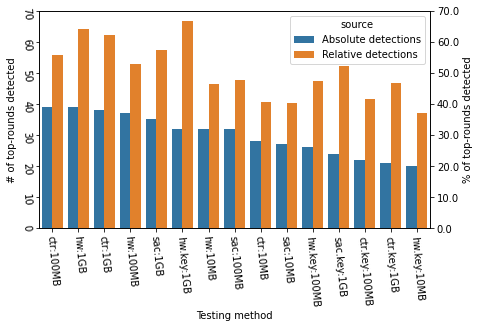


Most successful top-round unique detection methods
\item     4: hw:1048576000
\item     4: ctr:104857600
\item     3: ctr:1048576000
\item     2: hw.key:1048576000
\item     1: ctr.key:1048576000
\item     1: ctr.key:104857600

Most successful top-round detection methods (nosize)
\item   159: hw.key, pcnts: 64.37
\item   150: hw, pcnts: 54.95
\item   142: sac.key, pcnts: 59.17
\item   140: ctr.key, pcnts: 58.09
\item   134: ctr, pcnts: 46.69
\item    94: sac, pcnts: 36.58
\item    88: rnd.key, pcnts: 38.94
\item    49: hw.key..ornd.inp, pcnts: 42.98
\item    39: sac.key..ornd.inp, pcnts: 35.78
\item    32: ctr.key..ornd.inp, pcnts: 29.36
\item    31: zero, pcnts: 58.49


/tmp/ipykernel_1433345/3570914295.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(np.round(ax1.get_yticks()/scale,1))


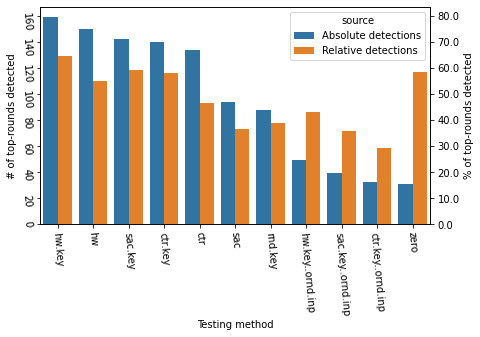


Most successful top-round detection sizes
\item   377: 1048576000
\item   376: 104857600
\item   305: 10485760


In [14]:
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Analysis for paper - high level statistics
# Test/Battery perspective

def get_test_desc(ctest):
    return test_db_inv[ctest] if ctest in test_db_inv else None

def get_batt_from_desc(tdesc):
    return tdesc.split('|')[0] if tdesc else None

def fix_meth_nm(meth):
    return meth.replace('::', ':').replace('lhw', 'hw')

def fix_size(size):
    return size if size <= 1024*1024*1000 else 1024*1024*1000

def human_size(size_txt):
    return size_txt.replace("1048576000", "1GB").replace("104857600", "100MB").replace("10485760", "10MB")

def pcnt_plot(data_plot_melted, id_col='meths', figsize=(8,6), col_scale='pcnts', cols=None, col_lbl_left="Totals", col_lbl_right="Relative"):
    # Scale the data, just a simple example of how you might determine the scaling
    mask = data_plot_melted.source.isin([col_scale])
    scale = int(data_plot_melted[~mask].value_numbers.mean()
                /data_plot_melted[mask].value_numbers.mean())
    data_plot_melted.loc[mask, 'value_numbers'] = data_plot_melted.loc[mask, 'value_numbers']*scale

    # Plot
    fig, ax1 = plt.subplots(figsize=figsize)
    g = sns.barplot(x=id_col, y="value_numbers", hue="source",\
                    data=data_plot_melted, ax=ax1)

    # Create a second y-axis with the scaled ticks
    ax1.set_ylabel(col_lbl_left)
    #ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 45)
    ax1.tick_params(labelrotation=275)
    ax2 = ax1.twinx()

    # Ensure ticks occur at the same positions, then modify labels
    ax2.set_ylim(ax1.get_ylim())
    ax2.set_yticklabels(np.round(ax1.get_yticks()/scale,1))
    ax2.set_ylabel(col_lbl_right)
    #ax2.set_xticklabels(ax2.get_xticklabels(),rotation = 30)
    #plt.xticks(rotation=45)
    plt.show()


# Compute conservative breaking rounds. 
# fname -> max meth
stat_rej_cons = default_dict_depth(1, lambda: None)      # fname -> const broken round
stat_rej_cons_key = default_dict_depth(1, lambda: None)  # fname -> const broken round by key method
stat_rej_cons_inp = default_dict_depth(1, lambda: None)  # fname -> const broken round by inp method

stat_rej_meths_cons = default_dict_depth(1, lambda: None)  # fname -> pairs of (meth, broken_round_cons), sorted DESC by round
stat_rej_cons_winning_meths = default_dict_depth(1, lambda: None)  # method list that broke the maximum rounds, conservative
stat_rej_cons_winning_inp_meths = default_dict_depth(1, lambda: None)  # method list that broke the maximum rounds, conservative
stat_rej_cons_winning_key_meths = default_dict_depth(1, lambda: None)  # method list that broke the maximum rounds, conservative
stat_rej_cons_winning_tests = default_dict_depth(1, lambda: None)  # test list that broke the maximum rounds, conservative
stat_rej_cons_winning_tests_noscore = default_dict_depth(1, lambda: None)  # test list that broke the maximum rounds, conservative
stat_has_key_method = default_dict_depth(1, lambda: False)

# TODO
stat_rej_batteries = default_dict_depth(1, lambda: None)  # fname -> pairs of (meth, broken_round_cons), sorted DESC by round

for fidx, fname in enumerate(stat_broken_rnds_cont.keys()):
    pairs = [(k, stat_broken_rnds_cont[fname][k]) for k in stat_broken_rnds_cont[fname].keys() if stat_broken_rnds_cont[fname][k] is not None]
    pairs.sort(key=lambda x: -x[1])

    stat_has_key_method[fname] = any('.key' in x[0] for x in pairs)
    stat_rej_meths_cons[fname] = pairs

    stat_rej_cons[fname] = pairs[0][1] if pairs else None
    if stat_rej_cons[fname] is None:
        continue

    stat_rej_cons_winning_meths[fname] = [x[0] for x in pairs if x[1] == stat_rej_cons[fname]]
    pairs_key = [x for x in pairs if '.key' in x[0]]
    pairs_nokey = [x for x in pairs if '.key' not in x[0]]
    stat_rej_cons_key[fname] = pairs_key[0][1] if pairs_key else None
    stat_rej_cons_inp[fname] = pairs_nokey[0][1] if pairs_nokey else None

    stat_rej_cons_winning_key_meths[fname] = [x[0] for x in pairs if pairs_key and x[1] == pairs_key[0][1]]
    stat_rej_cons_winning_inp_meths[fname] = [x[0] for x in pairs if pairs_nokey and x[1] == pairs_nokey[0][1]]

    cctr = collections.Counter()
    accset = set()
    for wmeth in stat_rej_cons_winning_meths[fname]:
        rej_base = stat_rej_tests_rep_seg[fname][wmeth][stat_rej_cons[fname]]  # pick (test, cnt) for breaking fname-meth-round
        rej_tests = [x for x in rej_base.keys() if rej_base[x] >= 2]
        accset = accset.union(rej_tests)

        tcctr = collections.Counter( { x: rej_base[x] for x in rej_base.keys() if rej_base[x] >= 1 } )
        cctr += tcctr

    stat_rej_cons_winning_tests[fname] = cctr
    stat_rej_cons_winning_tests_noscore[fname] = accset


# Compute methods used for fname-round 
# stat_all_tests = default_dict_depth(3, lambda: list())          # ftype:fname -> meth -> round -> [testidx]; list of all tests
stat_methods_used = default_dict_depth(2, lambda: set())          # ftype:fname -> round -> meth set
stat_methods_used_ctr = collections.Counter()
stat_methods_used_topr_ctr = collections.Counter()
stat_methods_used_methnosize_ctr = collections.Counter()
stat_methods_used_methnosize_topr_ctr = collections.Counter()
for fname, meth, rnd, tests in iterate_flatmap(stat_all_tests, 3):
    meth = fix_meth_nm(meth)
    stat_methods_used[fname][rnd].add(meth)
    meth_parts = meth.split(':')
    meth_tp, meth_size = meth_parts[0], int(meth_parts[-1])
    stat_methods_used_ctr[meth] += 1
    stat_methods_used_methnosize_ctr[meth_tp] += 1
    if rnd == stat_rej_cons[fname]:
        stat_methods_used_topr_ctr[meth] += 1
        stat_methods_used_methnosize_topr_ctr[meth_tp] += 1

# Most contributing batteries
# stat_only_rej_battery = collections.Counter()
# stat_only_rej_battery_allrnd = collections.Counter()

# for fname, meth, rnd, tests in iterate_flatmap(stat_rej_tests, 3):
#     all_tests = stat_all_tests[fname][meth][rnd]
#     rej_tests = stat_rej_tests[fname][meth][rnd]
#     all_batt_ctr = collections.Counter()
#     rej_bat_ctr = collections.Counter()
#     for ctest in all_tests:
#         all_batt_ctr[get_batt_from_desc(get_test_desc(ctest))] += 1
#     for ctest in rej_tests:
#         rej_bat_ctr[get_batt_from_desc(get_test_desc(ctest))] += 1

#     if len(rej_bat_ctr) == 1:
#         cbat = list(rej_bat_ctr.keys())[0]
#         # print(f'Only rejecting battery {fname} {meth} {rnd} {cbat}')
#         stat_only_rej_battery_allrnd[cbat] += 1
#         if rnd == stat_broken_rnds_cont[fname][meth]:  # last breaking round
#             stat_only_rej_battery[cbat] += 1

#     for cbat in rej_bat_ctr.keys():
#         rej_ratio = rej_bat_ctr[cbat] / all_batt_ctr[cbat]
        
#         # rejection ratio contributing; rej ratio only one battery?
#         if rnd == stat_broken_rnds_cont[fname][meth]:  # last breaking round
#             pass
    
# stat_only_rej_battery = [(k, stat_only_rej_battery[k]) for k in stat_only_rej_battery.keys()]
# stat_only_rej_battery.sort(key=lambda x: -x[1])
# stat_only_rej_battery_allrnd = [(k, stat_only_rej_battery_allrnd[k]) for k in stat_only_rej_battery_allrnd.keys()]
# stat_only_rej_battery_allrnd.sort(key=lambda x: -x[1])
# print('\nSingle detection battery per fname/round/method, all rounds')
# for p in itertools.islice(stat_only_rej_battery_allrnd, 10):
#     print(f' {p[0]}: {p[1]}')
# print('\nSingle detection battery per fname/round/method, top round')
# for p in itertools.islice(stat_only_rej_battery, 10):
#     print(f' {p[0]}: {p[1]}')


# Most successful tests and batteriess
stat_winning_tests_ctr = collections.Counter()
batt_uniq_map_ctr = default_dict_depth(1, lambda: collections.Counter())
for fname, fset in iterate_flatmap(stat_rej_cons_winning_tests_noscore, 1):
    for ctest in fset:
        stat_winning_tests_ctr[ctest] += 1
        batt = test_db_inv[ctest].split('|')[0]
        batt_uniq_map_ctr[fname][batt] += 1

stat_winning_tests = [(k, stat_winning_tests_ctr[k]) for k in stat_winning_tests_ctr.keys()]
stat_winning_tests.sort(key=lambda x: -x[1])

# TODO: Normalize to number of tests to battery?
print('\nBatteries catching most of the top rounds')
batt_ctr = collections.Counter()
for trec in stat_winning_tests:
    tdesc = test_db_inv[trec[0]]
    batt = tdesc.split('|')[0]
    batt_ctr[batt] += 1

stat_winning_bats = [(k, batt_ctr[k]) for k in dict(batt_ctr).keys()]
stat_winning_bats.sort(key=lambda x: -x[1])
for i in range(min(len(stat_winning_bats), 20)):
    trec = stat_winning_tests[i]
    tdesc = test_db_inv[trec[0]]
    print(f'{"%5d" % stat_winning_bats[i][1]}: {stat_winning_bats[i][0]}')

print(f'\nBatteries breaking cons rounds, unique')
batt_uniq_ctr = collections.Counter()
for fname in batt_uniq_map_ctr.keys():
    trec = dict(batt_uniq_map_ctr[fname])
    if len(trec) != 1: continue
    #print(fname, trec)
    batt_uniq_ctr[list(trec.keys())[0]] += 1
print(batt_uniq_ctr)

print('\nTests catching most of the top rounds')
stat_winning_tests_named = [(x[1], test_db_inv[x[0]]) for x in stat_winning_tests]
stat_winning_tests_named.sort(key=lambda x: (-x[0], x[1]))
for trec in itertools.islice(stat_winning_tests_named, 13):
    print(f'{"%5d" % trec[0]}: {trec[1]}')

# Winning methods
#  stat_rej_cons_winning_meths
stat_rej_cons_winning_meths_ctr = collections.Counter()
stat_rej_cons_winning_meths_uniq_ctr = collections.Counter()
for fname, fset in iterate_flatmap(stat_rej_cons_winning_meths, 1):
    for ctest in fset:
        stat_rej_cons_winning_meths_ctr[fix_meth_nm(ctest)] += 1
    if len(fset) == 1:
        stat_rej_cons_winning_meths_uniq_ctr[fix_meth_nm(fset[0])] += 1

stat_rej_cons_winning_meths_pairs = [(k, stat_rej_cons_winning_meths_ctr[k]) for k in stat_rej_cons_winning_meths_ctr.keys()]
stat_rej_cons_winning_meths_pairs.sort(key=lambda x: -x[1])
stat_rej_cons_winning_meths_uniq_pairs = [(k, stat_rej_cons_winning_meths_uniq_ctr[k]) for k in stat_rej_cons_winning_meths_uniq_ctr.keys()]
stat_rej_cons_winning_meths_uniq_pairs.sort(key=lambda x: -x[1])
print(f'\nMost successful top-round detection methods')
for trec in itertools.islice(stat_rej_cons_winning_meths_pairs, 30):
    print(f'\\item {"%5d" % trec[1]}: {trec[0]}, pcnts: {"%.2f" % (100 * trec[1] / stat_methods_used_topr_ctr[trec[0]])}')

stat_rej_cons_winning_meths_pairs_slice = list(itertools.islice(stat_rej_cons_winning_meths_pairs, 15))

cols = ["Testing method", "Absolute detections", "Relative detections"]
col_lbls = ["# of top-rounds detected", "% of top-rounds detected"]
data_plot = pd.DataFrame({
    cols[0]: [human_size(x[0]) for x in stat_rej_cons_winning_meths_pairs_slice],
    cols[1]: [x[1] for x in stat_rej_cons_winning_meths_pairs_slice], 
    cols[2]: [(100 * x[1] / stat_methods_used_topr_ctr[x[0]]) for x in stat_rej_cons_winning_meths_pairs_slice]})
data_plot_melted = pd.melt(data_plot, id_vars=cols[0], var_name="source", value_name="value_numbers")
pcnt_plot(data_plot_melted, figsize=(7,4), id_col=cols[0], col_scale=cols[1], cols=cols, col_lbl_left=col_lbls[0], col_lbl_right=col_lbls[1])

print('\nMost successful top-round unique detection methods')
for trec in itertools.islice(stat_rej_cons_winning_meths_uniq_pairs, 30):
    print(f'\\item {"%5d" % trec[1]}: {trec[0]}')

# Aggregate by meth, by size
stat_rej_cons_winning_methsnosize = collections.Counter()
stat_rej_cons_winning_size = collections.Counter()
for trec in stat_rej_cons_winning_meths_pairs:
    meth_parts = fix_meth_nm(trec[0]).split(':')
    meth_tp, meth_size = meth_parts[0], fix_size(int(meth_parts[-1]))
    stat_rej_cons_winning_methsnosize[meth_tp] += trec[1]
    stat_rej_cons_winning_size[meth_size] += trec[1]

stat_rej_cons_winning_methsnosize_pairs = [(k, stat_rej_cons_winning_methsnosize[k]) for k in stat_rej_cons_winning_methsnosize.keys()]
stat_rej_cons_winning_methsnosize_pairs.sort(key=lambda x: -x[1])
stat_rej_cons_winning_size_pairs = [(k, stat_rej_cons_winning_size[k]) for k in stat_rej_cons_winning_size.keys()]
stat_rej_cons_winning_size_pairs.sort(key=lambda x: -x[1])

print('\nMost successful top-round detection methods (nosize)')
for trec in itertools.islice(stat_rej_cons_winning_methsnosize_pairs, 30):
    print(f'\\item {"%5d" % trec[1]}: {trec[0]}, pcnts: {"%.2f" % (100 * trec[1] / stat_methods_used_methnosize_topr_ctr[trec[0]])}')

data_plot = pd.DataFrame({
    cols[0]: [x[0] for x in stat_rej_cons_winning_methsnosize_pairs],
    cols[1]: [x[1] for x in stat_rej_cons_winning_methsnosize_pairs], 
    cols[2]: [100 * x[1] / stat_methods_used_methnosize_topr_ctr[x[0]] for x in stat_rej_cons_winning_methsnosize_pairs]})

# plt.figure(figsize=(16, 12))
# ax = sns.barplot(x="meths", y="totals", data=data_plot)
# plt.show()
# ax = sns.barplot(x="meths", y="pcnts", data=data_plot)
# plt.show()

data_plot_melted = pd.melt(data_plot, id_vars=cols[0], var_name="source", value_name="value_numbers")
pcnt_plot(data_plot_melted, figsize=(7,4), id_col=cols[0], col_scale=cols[2], cols=cols, col_lbl_left=col_lbls[0], col_lbl_right=col_lbls[1])

print('\nMost successful top-round detection sizes')
for trec in itertools.islice(stat_rej_cons_winning_size_pairs, 30):
    print(f'\\item {"%5d" % trec[1]}: {trec[0]}')




Key method vs input method summary
Key better B:B:TEA, r32, input r5. Advantage: 27, Methods 5, input: []
Key better B:B:GOST, r29, input r10. Advantage: 19, Methods 1: (['hw.key:1048576000']), input: []
Key better B:B:ROBIN, r16, input r2. Advantage: 14, Methods 4, input: []
Key better B:B:TRIPLE-DES, r16, input r3. Advantage: 13, Methods 14, input: []
Key better B:B:SHACAL2, r21, input r9. Advantage: 12, Methods 4, input: []
Key better B:B:SINGLE-DES, r16, input r7. Advantage: 9, Methods 14, input: []
Key better B:S:Grain, r11, input r6. Advantage: 5, Methods 1: (['ctr.key:1048576000']), input: []
Key better B:B:IDEA, r6, input r1. Advantage: 5, Methods 1: (['hw.key:1048576000']), input: []
Key better B:B:LED, r7, input r3. Advantage: 4, Methods 12, input: []
Key better B:S:SOSEMANUK, r8, input r4. Advantage: 4, Methods 4, input: []
Key better B:B:XTEA, r8, input r4. Advantage: 4, Methods 2: (['hw.key..ornd.inp:1048576000', 'hw.key:1048576000']), input: []
Key better B:S:F-FCSR, r5,

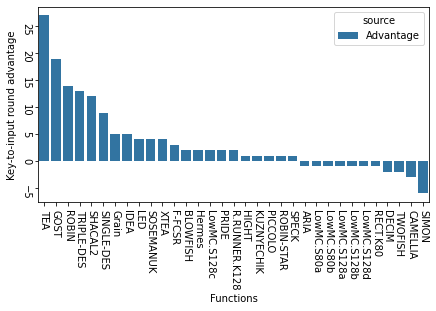

In [15]:
# Key methods vs normal methods. Best in both categories.
# TODO: compute absolute numbers, key method applicable only sometimes. Compute key success rate when all key methods were applied - i.e., do not take hash functions into account
print('\nKey method vs input method summary')
stat_key_cmp = []
for fname in stat_rej_cons_key.keys():
    brk_key = stat_rej_cons_key[fname]
    brk_inp = stat_rej_cons_inp[fname]
    if brk_key is None: continue
    diff = brk_key - brk_inp if brk_inp else brk_key
    stat_key_cmp.append((diff, fname, brk_key, brk_inp))
stat_key_cmp.sort(key=lambda x: -x[0])

ctr_key_better = 0
ctr_key_same = 0
ctr_key_worse = 0

gdata = []
for diff, fname, brk_key, brk_inp in stat_key_cmp:
    if fname.startswith('P::'):
        continue
    meths = stat_rej_cons_winning_key_meths[fname]
    meths_key = f'{len(meths)}: ({meths})' if len(meths) <= 3 else f'{len(meths)}'
    meths_inp = []  # stat_rej_cons_winning_key_meths[fname]
    if brk_inp is None or brk_key > brk_inp:
        ctr_key_better += 1
        if brk_inp is None:
            print(f'Key better {fname}, r{brk_key}, input didnt reject. Methods: {meths_key}')
        else:
            print(f'Key better {fname}, r{brk_key}, input r{brk_inp}. Advantage: {brk_key - brk_inp}, Methods {meths_key}, input: {meths_inp}')

    elif brk_inp is not None and brk_key == brk_inp:
        ctr_key_same += 1
        print(f'Key same as input {fname}, r{brk_key}. Methods {meths_key}, input: {meths_inp}')

    else:
        ctr_key_worse += 1
        print(f'Key worse than input {fname}, r{brk_key}, input r{brk_inp}. Advantage: {brk_inp - brk_key}, Methods {meths_key}, input: {meths_inp}')
    pfname = paper_fname(fname[4:])
    gdata.append((pfname, brk_key - brk_inp if brk_inp is not None else 0, len(meths)))

ctr_better_all = ctr_key_better + ctr_key_same + ctr_key_worse
print(f'Key better: {ctr_key_better} ~ {"%.2f" % (100*ctr_key_better/ctr_better_all)}, same: {ctr_key_same} ~ {"%.2f" % (100*ctr_key_same/ctr_better_all)}, '
      f'input better: {ctr_key_worse} ~ {"%.2f" % (100*ctr_key_worse/ctr_better_all)}')

gdata2 = [x for x in gdata if x[1] != 0]
data_plot = pd.DataFrame({
    "Functions": [x[0] for x in gdata2],
    "Advantage": [x[1] for x in gdata2], 
#    "Methods": [x[2] for x in gdata2]
})
print(data_plot)
data_plot_melted = pd.melt(data_plot, id_vars="Functions", var_name="source", value_name="value_numbers")

# Scale the data, just a simple example of how you might determine the scaling
mask = data_plot_melted.source.isin(["Advantage"])
#scale = int(data_plot_melted[~mask].value_numbers.mean()
#            /data_plot_melted[mask].value_numbers.mean())
scale=1            
data_plot_melted.loc[mask, 'value_numbers'] = data_plot_melted.loc[mask, 'value_numbers']*scale
print(f' -- Scale: {scale}, {data_plot_melted[~mask].value_numbers.mean()}, {data_plot_melted[mask].value_numbers.mean()}')
# print(data_plot_melted)

# Plot
fig, ax1 = plt.subplots(figsize=(7,3.6))
g = sns.barplot(x="Functions", y="value_numbers", hue="source",\
                data=data_plot_melted, ax=ax1)

# Create a second y-axis with the scaled ticks
ax1.set_ylabel('Key-to-input round advantage')
#ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 45)
ax1.tick_params(labelrotation=270)

# ax2 = ax1.twinx()
# ax2.set_ylim(ax1.get_ylim())  # Ensure ticks occur at the same positions, then modify labels
# ax2.set_yticklabels(np.round(ax1.get_yticks()/scale,1))
# ax2.set_ylabel('# of methods')
# #ax2.set_xticklabels(ax2.get_xticklabels(),rotation = 30)
# #plt.xticks(rotation=45)

plt.show()

# TODO: confidence metric
# TODO: adding size increases advantage, how to visualize
# TODO: size, unconfirmed when size increases.
# for fname in stat_rej_cons_winning_tests_noscore.keys():
    # for wtest in stat_rej_cons_winning_tests_noscore[fname]
    # stat_winning_tests_ctr

#for fname, meth, res in iterate_flatmap(stat_rej_tests_seg, 2):
#    print(fname, meth, res)

# aggregate method paths, maximal size
#for fname, meth, res in iterate_flatmap(stat_rej_tests_rep_seg, 2):
#    print(fname, meth, res)


In [16]:
# Compute data like: more data -> less detections, more data -> more detections
stat_by_meths = default_dict_depth(4, lambda: None)               # ftype:fname -> meth -> round -> size -> reject
# stat_all_tests = default_dict_depth(3, lambda: list())          # ftype:fname -> meth -> round -> [testidx]; list of all tests
# stat_rej_rounds_segments = default_dict_depth(2, lambda: None)  # ftype:fname -> meth -> segments; rejection segments, list of consecutively broken rounds
for fname, meth, rnd, tests in iterate_flatmap(stat_all_tests, 3):
    meth_parts = meth.split(':')
    meth_tp, meth_size = meth_parts[0], int(meth_parts[-1])
    stat_by_meths[fname][meth_tp][rnd][meth_size] = False

for fname, meth, segments in iterate_flatmap(stat_rej_rounds_segments, 2):
    if segments is None or len(segments) == 0 or (len(segments) == 1 and not segments[0]):
        continue
    meth_parts = meth.split(':')
    meth_tp, meth_size = meth_parts[0], int(meth_parts[-1])
    for seg in segments:
        for rnd in seg:
            stat_by_meths[fname][meth_tp][rnd][meth_size] = True

ctr_datadet_consistent = []
ctr_datadet_consistent_det = []
ctr_datadet_weird = []
ctr_datadet_progression = []
ctr_datadet_regression = []
for fname, meth, rnd, sizes in iterate_flatmap(stat_by_meths, 3):
    ssizes = sorted(list(sizes.items()))
    if len(ssizes) <= 1: 
        continue
    
    # groupby result on csize[1] ~ broken or not. Merge continuous segments
    size_segs = [[]]
    for ix, csize in enumerate(ssizes):
        if size_segs[-1] and csize[1] != size_segs[-1][0][1]:
            size_segs.append([])
        size_segs[-1].append(csize)

    if len(size_segs) == 2:
        if size_segs[0][0][1] == False:
            ctr_datadet_progression.append((fname, meth, rnd, size_segs[0][-1], size_segs))
        else:
            ctr_datadet_regression.append((fname, meth, rnd, size_segs[0][-1], size_segs))
    elif len(size_segs) == 1:
        ctr_datadet_consistent.append((fname, meth, rnd, size_segs))
        if size_segs[0][-1][1]:
            ctr_datadet_consistent_det.append((fname, meth, rnd, size_segs))
    elif len(size_segs) > 2:
        ctr_datadet_weird.append((fname, meth, rnd, size_segs))

total_detections = len(ctr_datadet_progression) + len(ctr_datadet_regression) + len(ctr_datadet_consistent_det) + len(ctr_datadet_weird)
print(f'Data progression: {len(ctr_datadet_progression)} ~ {"%.2f" % (100*len(ctr_datadet_progression)/total_detections)}%, '
      f'regression: {len(ctr_datadet_regression)} ~ {"%.2f" % (100*len(ctr_datadet_regression)/total_detections)}%, '
      f'consistent: {len(ctr_datadet_consistent)}, '
      f'const detect: {len(ctr_datadet_consistent_det)} ~ {"%.2f" % (100*len(ctr_datadet_consistent_det)/total_detections)}%, '
      f'weird: {len(ctr_datadet_weird)} ~ {"%.2f" % (100*len(ctr_datadet_weird)/total_detections)}%')

print(f'\nData progression')
for x in itertools.islice(ctr_datadet_progression, 20):
    print(f'  {x}')

print(f'\nData regression:')
for x in ctr_datadet_regression:
    print(f'  {x}')

print(f'\nWeirdlings:')
for x in ctr_datadet_weird:
    print(f'  {x}')

# Data progression per rounds
csizes = (10485760, 104857600, 1048576000)  # TODO: extend if needed
size_prog_res = []
for fname, meth, rnd_sizes in iterate_flatmap(stat_by_meths, 2):
    rounds = sorted(list(rnd_sizes.keys()))
    used_rounds = []
    highest_rounds = {}

    for r in reversed(rounds):
        for csize in csizes:
            if csize in highest_rounds or not rnd_sizes[r][csize]:
                continue
            highest_rounds[csize] = r
            used_rounds.append(r)

    if not highest_rounds:
        continue

    size_prog_res.append((fname, meth, highest_rounds, max(used_rounds) - min(used_rounds), max(used_rounds)))
size_prog_res.sort(key=lambda x: (-x[4], -x[3],))

print(f'\n\nRounds progression with sizes')
for row in itertools.islice(size_prog_res, 550):
    ssizes = sorted(list(row[2].keys()))
    sizes_txt = ", ".join([f'{sz}: {row[2][sz]}' for sz in ssizes])
    print(f'{"%30s" % row[0]} | {"%20s" % row[1]} | {"%3d" % row[3]} | {sizes_txt}')

Data progression: 403 ~ 19.21%, regression: 1 ~ 0.05%, consistent: 5116, const detect: 1693 ~ 80.70%, weird: 1 ~ 0.05%

Data progression
  ('B:B:AES', 'hw.key..ornd.inp', 3, (104857600, False), [[(10485760, False), (104857600, False)], [(1048576000, True)]])
  ('B:B:AES', 'hw.key', 3, (10485760, False), [[(10485760, False)], [(104857600, True), (1048576000, True)]])
  ('B:B:AES', 'rnd.key', 1, (10485760, False), [[(10485760, False)], [(104857600, True), (1048576000, True)]])
  ('B:B:AES', 'sac', 3, (10485760, False), [[(10485760, False)], [(104857600, True), (1048576000, True)]])
  ('B:B:ARIA', 'hw.key..ornd.inp', 1, (10485760, False), [[(10485760, False)], [(104857600, True), (1048576000, True)]])
  ('B:B:ARIA', 'hw.key', 1, (10485760, False), [[(10485760, False)], [(104857600, True), (1048576000, True)]])
  ('B:B:ARIA', 'sac.key..ornd.inp', 1, (10485760, False), [[(10485760, False)], [(104857600, True), (1048576000, True)]])
  ('B:B:ARIA', 'sac.key', 1, (10485760, False), [[(10485760

In [18]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_1287901/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [ ]:
# Redefine Function DB - years updates
class FConstType:
    SPN = 1
    FN = 2    # Feistel
    GFN = 3   # gen Feistel
    ARX = 4  # add–rotate–XOR
    NLFSR = 5
    HYBRID = 6
    LMS = 7
    HASH = 8

    MPRENEL = 1
    MERKLED = 2
    SPONGE = 3


class FuncInfo:
    HASH = 1
    CIPHER = 2
    PRNG = 3

    NONE = 0
    BLOCK = 1
    STREAM = 2
    LIGHT = 3
    MPC = 4

    def __init__(self, fname, ftype, stype=None, max_rounds=None, human_broken_rounds=None, partial_rounds=None,
                 block_size=None, key_size=None, iv_size=None, year=None, ctype=None):
        self.fname = fname
        self.ftype = ftype
        self.stype = stype or 0
        self.max_rounds = max_rounds
        self.partial_rounds = partial_rounds
        self.human_broken_rounds = human_broken_rounds
        self.block_size = block_size
        self.key_size = key_size
        self.iv_size = iv_size
        self.year = year
        self.ctype = ctype

    def get_alg_type(self):
        return get_alg_type(self.ftype, self.stype)

    def __repr__(self):
        return f'FuncInfo({self.fname}, ft: {self.ftype}, st: {self.stype}, r: {self.max_rounds})'

    @staticmethod
    def from_str(x):
        if x in ('block', 'stream_cipher'):
            return FuncInfo.CIPHER
        elif x == 'prng':
            return FuncInfo.PRNG
        elif x == 'hash':
            return FuncInfo.HASH
        else:
            raise ValueError(f'Unknown type: {x}')

FUNC_DB = FuncDb()
FUNC_DB.add_all([
    FuncInfo('ABC', FuncInfo.HASH, None, 9, None),  # v3, https://eprint.iacr.org/2010/658.pdf
    FuncInfo('Achterbahn', FuncInfo.HASH, None, 1, None),  # https://en.wikipedia.org/wiki/Achterbahn no rounds
    FuncInfo('DICING', FuncInfo.HASH, None, None, None),
    FuncInfo('Dragon', FuncInfo.HASH, None, None, None),  # https://www.ecrypt.eu.org/stream/p3ciphers/dragon/dragon_p3.pdf

    FuncInfo('AES', FuncInfo.CIPHER, None, 10, 6, block_size=16, key_size=16, iv_size=16, year=2001, ctype=FConstType.SPN),
    FuncInfo('ARIA', FuncInfo.CIPHER, None, 12, 4, block_size=16, key_size=16, iv_size=16, year=2003, ctype=FConstType.SPN),  # https://en.wikipedia.org/wiki/ARIA_(cipher)
    FuncInfo('Blowfish', FuncInfo.CIPHER, None, 16, 4, block_size=8, key_size=32, iv_size=16, year=1993, ctype=FConstType.FN),
    FuncInfo('Camelia', FuncInfo.CIPHER, None, 18, 8, block_size=16, key_size=16, iv_size=16, year=2000, ctype=FConstType.FN),
    FuncInfo('Camellia', FuncInfo.CIPHER, None, 18, 8, block_size=16, key_size=16, iv_size=16, year=2000, ctype=FConstType.FN),
    FuncInfo('Cast', FuncInfo.CIPHER, None, 12, 9, block_size=8, key_size=16, iv_size=16, year=1996, ctype=FConstType.FN),  # https://en.wikipedia.org/wiki/CAST-128
    FuncInfo('Chaskey', FuncInfo.CIPHER, FuncInfo.LIGHT, 16, 7, block_size=16, key_size=16, iv_size=16, year=2014, ctype=FConstType.ARX),  # https://mouha.be/chaskey/
    FuncInfo('Fantomas', FuncInfo.CIPHER, None, 12, 5, block_size=16, key_size=16, iv_size=16, year=2014, ctype=FConstType.SPN),  # https://www.mdpi.com/2410-387X/3/1/4/htm https://who.paris.inria.fr/Gaetan.Leurent/files/LS_FSE14.pdf
    FuncInfo('Gost', FuncInfo.CIPHER, None, 32, 20, block_size=8, key_size=32, iv_size=16, year=1994, ctype=FConstType.FN),  # https://cryptography.fandom.com/wiki/GOST_(block_cipher), att: https://eprint.iacr.org/2011/312.pdf https://eprint.iacr.org/2017/487.pdf
    FuncInfo('Hight', FuncInfo.CIPHER, FuncInfo.LIGHT, 32, 18, block_size=8, key_size=16, iv_size=16, year=2006, ctype=FConstType.FN),  # https://link.springer.com/chapter/10.1007/11894063_4 https://ieeexplore.ieee.org/document/8109901./ https://www.researchgate.net/profile/Bing-Sun-14/publication/221282558_Saturation_Attack_on_the_Block_Cipher_HIGHT/ https://eprint.iacr.org/2018/688.pdf
    FuncInfo('Idea', FuncInfo.CIPHER, None, 8, 4, block_size=8, key_size=16, iv_size=16, year=1991, ctype=FConstType.LMS),  # https://en.wikipedia.org/wiki/International_Data_Encryption_Algorithm
    FuncInfo('Kasumi', FuncInfo.CIPHER, None, 8, 8, block_size=8, key_size=16, iv_size=16, year=2005, ctype=FConstType.FN),
    FuncInfo('KUZNYECHIK', FuncInfo.CIPHER, None, 10, 4, block_size=16, key_size=32, iv_size=16, year=2015, ctype=FConstType.SPN),  # https://en.wikipedia.org/wiki/Kuznyechik
    FuncInfo('LBLOCK', FuncInfo.CIPHER, None, 32, 24, block_size=8, key_size=10, iv_size=16, year=2011, ctype=FConstType.FN),
    FuncInfo('LEA', FuncInfo.CIPHER, None, 24, 8, block_size=16, key_size=16, iv_size=16, year=2013, ctype=FConstType.ARX),  # https://ieeexplore.ieee.org/document/8109901./keywords#keywords https://eprint.iacr.org/2018/688.pdf
    FuncInfo('LED', FuncInfo.CIPHER, None, 48, None, block_size=8, key_size=10, iv_size=16, year=2010, ctype=FConstType.SPN),
    FuncInfo('MARS', FuncInfo.CIPHER, None, 16, 8, block_size=16, key_size=16, iv_size=16, year=1999, ctype=FConstType.FN),  # https://eprint.iacr.org/2006/217.pdf
    FuncInfo('MISTY1', FuncInfo.CIPHER, None, 8, 6, block_size=8, key_size=16, iv_size=16, year=1995, ctype=FConstType.FN),
    FuncInfo('NOEKEON', FuncInfo.CIPHER, None, 16, 4, block_size=16, key_size=16, iv_size=16, year=2009, ctype=FConstType.SPN),  # https://en.wikipedia.org/wiki/NOEKEON
    FuncInfo('PICCOLO', FuncInfo.CIPHER, None, 25, 5, block_size=8, key_size=10, iv_size=16, year=2011, ctype=FConstType.FN),  # https://www.koreascience.or.kr/article/JAKO201932365651180.page
    FuncInfo('PRIDE', FuncInfo.CIPHER, None, 20, 19, block_size=8, key_size=16, iv_size=16, year=2014, ctype=FConstType.SPN),  # https://eprint.iacr.org/2014/656.pdf
    FuncInfo('Prince', FuncInfo.CIPHER, None, 12, 6, block_size=8, key_size=16, iv_size=16, year=2012, ctype=FConstType.SPN),  # https://en.wikipedia.org/wiki/Prince_(cipher)
    FuncInfo('RC5-20', FuncInfo.CIPHER, None, 20, 17, block_size=8, key_size=16, iv_size=16, year=1997, ctype=FConstType.FN),  # https://media.hotnews.ro/media_server1/document-2012-05-9-12207779-0-articolul-semnat-ioan-mang.pdf
    FuncInfo('RC6', FuncInfo.CIPHER, None, 20, 5, block_size=16, key_size=16, iv_size=16, year=1997, ctype=FConstType.GFN),  # https://www.cryptrec.go.jp/exreport/cryptrec-ex-1086-2000.pdf  https://media.hotnews.ro/media_server1/document-2012-05-9-12207779-0-articolul-semnat-ioan-mang.pdf
    FuncInfo('RECTANGLE-K128', FuncInfo.CIPHER, FuncInfo.LIGHT, 25, 14, block_size=8, key_size=16, iv_size=16, year=2014, ctype=FConstType.SPN),  # https://eprint.iacr.org/2014/084.pdf
    FuncInfo('RECTANGLE-K80', FuncInfo.CIPHER, FuncInfo.LIGHT, 25, 18, block_size=8, key_size=10, iv_size=16, year=2014, ctype=FConstType.SPN),
    FuncInfo('ROAD-RUNNER-K128', FuncInfo.CIPHER, FuncInfo.LIGHT, 12, 8, block_size=8, key_size=16, iv_size=16, year=2015, ctype=FConstType.FN),  # https://eprint.iacr.org/2015/906.pdf  https://eprint.iacr.org/2018/688.pdf
    FuncInfo('ROAD-RUNNER-K80', FuncInfo.CIPHER, FuncInfo.LIGHT, 10, 8, block_size=8, key_size=10, iv_size=16, year=2015, ctype=FConstType.FN),  # https://eprint.iacr.org/2018/688.pdf
    FuncInfo('ROBIN', FuncInfo.CIPHER, None, 16, 16, block_size=16, key_size=16, iv_size=16, year=2014, ctype=FConstType.SPN),  # https://who.paris.inria.fr/Gaetan.Leurent/files/LS_FSE14.pdf
    FuncInfo('ROBIN-STAR', FuncInfo.CIPHER, None, 16, None, block_size=16, key_size=16, iv_size=16, year=2017, ctype=FConstType.SPN),  # https://fenix.tecnico.ulisboa.pt/downloadFile/281870113704550/Extended_Abstract-Choosing_the_Future_of_Lightweight_Encryption_Algorithms.pdf
    FuncInfo('SEED', FuncInfo.CIPHER, None, 16, None, block_size=16, key_size=16, iv_size=16, year=1998, ctype=FConstType.FN),  # https://en.wikipedia.org/wiki/SEED
    FuncInfo('SERPENT', FuncInfo.CIPHER, None, 32, 5, block_size=16, key_size=16, iv_size=16, year=1998, ctype=FConstType.SPN),  # https://en.wikipedia.org/wiki/Serpent_(cipher)
    FuncInfo('SHACAL2', FuncInfo.CIPHER, None, 80, 44, block_size=32, key_size=64, iv_size=16, year=2000, ctype=FConstType.HASH),  # https://www.researchgate.net/publication/220237385_Attacking_44_Rounds_of_the_SHACAL-2_Block_Cipher_Using_Related-Key_Rectangle_Cryptanalysis https://github.com/odzhan/tinycrypt/blob/master/block/shacal2/doc/10.1.1.3.4066.pdf
    FuncInfo('SIMON', FuncInfo.CIPHER, None, 68, 26, block_size=16, key_size=16, iv_size=16, year=2013, ctype=FConstType.SPN),  # https://eprint.iacr.org/2018/688.pdf
    FuncInfo('SINGLE-DES', FuncInfo.CIPHER, None, 16, 16, block_size=8, key_size=7, iv_size=16, year=1977, ctype=FConstType.FN),  # https://en.wikipedia.org/wiki/Data_Encryption_Standard
    FuncInfo('SPARX-B128', FuncInfo.CIPHER, FuncInfo.LIGHT, 32, 8, block_size=16, key_size=16, iv_size=16, year=2016, ctype=FConstType.ARX),  # https://www.cryptolux.org/index.php/SPARX
    FuncInfo('SPARX-B64', FuncInfo.CIPHER, FuncInfo.LIGHT, 24, 8, block_size=8, key_size=16, iv_size=16, year=2016, ctype=FConstType.ARX),
    FuncInfo('SPECK', FuncInfo.CIPHER, FuncInfo.LIGHT, 32, 15, block_size=16, key_size=16, iv_size=16, year=2013, ctype=FConstType.ARX),
    FuncInfo('TEA', FuncInfo.CIPHER, FuncInfo.LIGHT, 32, 5, block_size=8, key_size=16, iv_size=16, year=1994, ctype=FConstType.FN),
    FuncInfo('TRIPLE-DES', FuncInfo.CIPHER, None, 16, None, block_size=8, key_size=21, iv_size=16, year=1981, ctype=FConstType.FN),  # https://en.wikipedia.org/wiki/Triple_DES
    FuncInfo('TWINE', FuncInfo.CIPHER, FuncInfo.LIGHT, 35, 23, block_size=8, key_size=10, iv_size=16, year=2011, ctype=FConstType.FN),  # https://www.nec.com/en/global/rd/tg/code/symenc/pdf/twine_LC11.pdf
    FuncInfo('TWOFISH', FuncInfo.CIPHER, None, 16, 16, block_size=16, key_size=16, iv_size=16, year=1998, ctype=FConstType.FN),  # https://en.wikipedia.org/wiki/Twofish
    FuncInfo('XTEA', FuncInfo.CIPHER, FuncInfo.LIGHT, 32, 8, block_size=8, key_size=16, iv_size=16, year=2017, ctype=FConstType.FN),

    FuncInfo('ARIRANG', FuncInfo.HASH, None, 4, 4, block_size=32, year=2008),  # https://ehash.iaik.tugraz.at/wiki/ARIRANG
    FuncInfo('AURORA', FuncInfo.HASH, None, 17, None, block_size=32, year=2008),  # https://ehash.iaik.tugraz.at/wiki/AURORA
    FuncInfo('Abacus', FuncInfo.HASH, None, 280, None, block_size=32, year=2008),  # https://ehash.iaik.tugraz.at/wiki/Abacus  broken: https://scholarworks.rit.edu/cgi/viewcontent.cgi?referer=&httpsredir=1&article=1653&context=theses
    FuncInfo('BLAKE', FuncInfo.HASH, None, 14, 4, block_size=32, year=2008, ctype=FConstType.ARX),  # https://ehash.iaik.tugraz.at/wiki/BLAKE
    FuncInfo('BMW', FuncInfo.HASH, None, 16, None, block_size=32, year=2008, ctype=FConstType.ARX),  # https://ehash.iaik.tugraz.at/wiki/Blue_Midnight_Wish  https://link.springer.com/content/pdf/10.1007%2F978-3-642-13858-4_17.pdf
    FuncInfo('Blender', FuncInfo.HASH, None, 32, None, block_size=64, year=2008),  # https://ehash.iaik.tugraz.at/wiki/Blender
    FuncInfo('Boole', FuncInfo.HASH, None, 16, 16, block_size=32, year=2008),  # https://ehash.iaik.tugraz.at/wiki/Boole  https://ehash.iaik.tugraz.at/uploads/3/37/BoolePaper.pdf
    FuncInfo('CHI', FuncInfo.HASH, None, 20, None, block_size=64, year=2008),  # https://ehash.iaik.tugraz.at/wiki/CHI
    FuncInfo('Cheetah', FuncInfo.HASH, None, 16, 12, block_size=32, year=2008),  # https://ehash.iaik.tugraz.at/wiki/Cheetah
    FuncInfo('CubeHash', FuncInfo.HASH, None, 8, None, block_size=32, year=2008),  # https://ehash.iaik.tugraz.at/wiki/CubeHash
    FuncInfo('DCH', FuncInfo.HASH, None, 4, 4, block_size=32, year=2008),  # https://ehash.iaik.tugraz.at/wiki/DCH
    FuncInfo('DynamicSHA', FuncInfo.HASH, None, 16, None, block_size=48, year=2008),  # https://ehash.iaik.tugraz.at/wiki/Dynamic_SHA
    FuncInfo('DynamicSHA2', FuncInfo.HASH, None, 17, 17, block_size=32, year=2008),  # https://ehash.iaik.tugraz.at/wiki/Dynamic_SHA2
    FuncInfo('ECHO', FuncInfo.HASH, None, 8, 4, block_size=32, year=2008),  # https://ehash.iaik.tugraz.at/wiki/ECHO
    FuncInfo('ESSENCE', FuncInfo.HASH, None, 32, 14, block_size=32, year=2008),  # https://ehash.iaik.tugraz.at/wiki/ESSENCE https://tsapps.nist.gov/publication/get_pdf.cfm?pub_id=904375 "Cryptanalysis of the ESSENCE Family of Hash Functions"
    FuncInfo('Gost', FuncInfo.HASH, None, 32, 5, block_size=32, year=1994),  # https://en.wikipedia.org/wiki/GOST_(hash_function)
    FuncInfo('Grostl', FuncInfo.HASH, None, 10, None, block_size=32, year=2008),  # https://ehash.iaik.tugraz.at/wiki/Groestl https://tosc.iacr.org/index.php/ToSC/article/view/763/721
    FuncInfo('Hamsi', FuncInfo.HASH, None, 3, None, block_size=32, year=2008),  # https://ehash.iaik.tugraz.at/wiki/Hamsi
    FuncInfo('JH', FuncInfo.HASH, None, 42, 10, block_size=32, year=2008),  # https://ehash.iaik.tugraz.at/wiki/JH
    FuncInfo('Keccak', FuncInfo.HASH, None, 24, 5, block_size=32, year=2008, ctype=FConstType.SPONGE),  # https://ehash.iaik.tugraz.at/wiki/Keccak
    FuncInfo('Lesamnta', FuncInfo.HASH, None, 32, 32, block_size=32, year=2008),  # https://ehash.iaik.tugraz.at/wiki/Lesamnta
    FuncInfo('Luffa', FuncInfo.HASH, None, 8, 8, block_size=32, year=2008),  # https://ehash.iaik.tugraz.at/wiki/Luffa
    FuncInfo('MCSSHA3', FuncInfo.HASH, None, 1, None, block_size=32, year=2008),  # https://ehash.iaik.tugraz.at/wiki/MCSSHA-3
    FuncInfo('MD5', FuncInfo.HASH, None, 64, None, block_size=16, year=1992, ctype=FConstType.MERKLED),  # https://ehash.iaik.tugraz.at/wiki/MD5
    FuncInfo('MD6', FuncInfo.HASH, None, 104, 16, block_size=32, year=2008),  # https://ehash.iaik.tugraz.at/wiki/MD6  https://scholarworks.rit.edu/cgi/viewcontent.cgi?referer=&httpsredir=1&article=1653&context=theses
    FuncInfo('RIPEMD160', FuncInfo.HASH, None, 80, 48, block_size=20, year=1992),  # https://ehash.iaik.tugraz.at/wiki/RIPEMD  https://en.wikipedia.org/wiki/RIPEMD  https://eprint.iacr.org/2012/049.pdf
    FuncInfo('SHA1', FuncInfo.HASH, None, 80, 80, block_size=20, year=1995, ctype=FConstType.MERKLED),  # https://en.wikipedia.org/wiki/SHA-1
    FuncInfo('SHA2', FuncInfo.HASH, None, 64, 31, block_size=32, year=2001, ctype=FConstType.MERKLED),  # https://en.wikipedia.org/wiki/SHA-2
    FuncInfo('SHA3', FuncInfo.HASH, None, 24, 5, block_size=32, year=2016, ctype=FConstType.SPONGE),  # https://en.wikipedia.org/wiki/SHA-3
    FuncInfo('SHAvite3', FuncInfo.HASH, None, 12, None, block_size=32, year=2008),  # https://ehash.iaik.tugraz.at/wiki/SHAvite-3
    FuncInfo('SIMD', FuncInfo.HASH, None, 4, None, block_size=32, year=2008),  # https://ehash.iaik.tugraz.at/wiki/SIMD
    FuncInfo('Sarmal', FuncInfo.HASH, None, 16, None, block_size=32, year=2008),  # https://ehash.iaik.tugraz.at/wiki/Sarmal
    FuncInfo('Shabal', FuncInfo.HASH, None, 1, None, block_size=32, year=2008),  # https://ehash.iaik.tugraz.at/wiki/Shabal
    FuncInfo('Skein', FuncInfo.HASH, None, 72, 17, block_size=32, year=2008),  # https://ehash.iaik.tugraz.at/wiki/Skein
    FuncInfo('TIB3', FuncInfo.HASH, None, 16, None, block_size=48, year=2008),  # https://ehash.iaik.tugraz.at/wiki/TIB3
    FuncInfo('Tangle', FuncInfo.HASH, None, 80, 80, block_size=32, year=2008),  # https://ehash.iaik.tugraz.at/wiki/Tangle  https://ehash.iaik.tugraz.at/uploads/4/40/Tangle.pdf
    FuncInfo('Tangle2', FuncInfo.HASH, None, 80, None, block_size=32, year=2008),
    FuncInfo('Tiger', FuncInfo.HASH, None, 23, 19, block_size=24, year=1996, ctype=FConstType.MERKLED),  # https://ehash.iaik.tugraz.at/wiki/Tiger
    FuncInfo('Twister', FuncInfo.HASH, None, 9, 9, block_size=32, year=2008),  # https://ehash.iaik.tugraz.at/wiki/Twister
    FuncInfo('Whirlpool', FuncInfo.HASH, None, 10, 10, block_size=64, year=2000, ctype=FConstType.MPRENEL),  # https://ehash.iaik.tugraz.at/wiki/Whirlpool  https://en.wikipedia.org/wiki/Whirlpool_(hash_function) https://diglib.tugraz.at/download.php?id=576a7a85b2dc5&location=browse "Analysis of Cryptographic Hash Functions"

    FuncInfo('Chacha', FuncInfo.CIPHER, FuncInfo.STREAM, 20, 6, block_size=32, key_size=32, iv_size=8, year=2008, ctype=FConstType.ARX),  # https://cr.yp.to/chacha.html  https://eprint.iacr.org/2018/688.pdf
    FuncInfo('DECIM', FuncInfo.CIPHER, FuncInfo.STREAM, 8, None, block_size=24, key_size=10, iv_size=8, year=2005),  # https://en.wikipedia.org/wiki/DECIM
    FuncInfo('F-FCSR', FuncInfo.CIPHER, FuncInfo.STREAM, 5, 5, block_size=16, key_size=16, iv_size=8, year=2005),  # https://en.wikipedia.org/wiki/F-FCSR  https://www.iacr.org/archive/asiacrypt2008/53500563/53500563.pdf
    FuncInfo('Fubuki', FuncInfo.CIPHER, FuncInfo.STREAM, 4, None, block_size=16, key_size=16, iv_size=16, year=2005),  # https://www.ecrypt.eu.org/stream/cryptmtfubuki.html
    FuncInfo('Grain', FuncInfo.CIPHER, FuncInfo.STREAM, 13, 13, block_size=16, key_size=16, iv_size=12, year=2005),  # https://www.ecrypt.eu.org/stream/grain.html https://www.researchgate.net/publication/220334177_An_Experimentally_Verified_Attack_on_Full_Grain-128_Using_Dedicated_Reconfigurable_Hardware  https://link.springer.com/content/pdf/10.1007/s11424-018-7170-4.pdf
    FuncInfo('HC-128', FuncInfo.CIPHER, FuncInfo.STREAM, 1, None, block_size=16, key_size=16, iv_size=16, year=2005),  # https://www.ecrypt.eu.org/stream/hc256.html
    FuncInfo('Hermes', FuncInfo.CIPHER, FuncInfo.STREAM, 10, None, block_size=16, key_size=10, iv_size=0, year=2005),  # https://www.ecrypt.eu.org/stream/hermes8.html
    FuncInfo('LEX', FuncInfo.CIPHER, FuncInfo.STREAM, 10, None, block_size=16, key_size=16, iv_size=16, year=2005),  # https://www.ecrypt.eu.org/stream/lex.html
    FuncInfo('MICKEY', FuncInfo.CIPHER, FuncInfo.STREAM, 1, None, block_size=16, key_size=16, iv_size=0, year=2005),
    FuncInfo('RC4', FuncInfo.CIPHER, FuncInfo.STREAM, 1, None, block_size=32, key_size=16, iv_size=0, year=1994),  # https://en.wikipedia.org/wiki/RC4
    FuncInfo('Rabbit', FuncInfo.CIPHER, FuncInfo.STREAM, 4, None, block_size=16, key_size=16, iv_size=8, year=2005),  # https://en.wikipedia.org/wiki/Rabbit_(cipher)
    FuncInfo('SOSEMANUK', FuncInfo.CIPHER, FuncInfo.STREAM, 25, None, block_size=16, key_size=16, iv_size=16, year=2005),  # https://en.wikipedia.org/wiki/SOSEMANUK
    FuncInfo('Salsa20', FuncInfo.CIPHER, FuncInfo.STREAM, 20, 6, block_size=8, key_size=16, iv_size=8, year=2007, ctype=FConstType.ARX),  # https://en.wikipedia.org/wiki/Salsa20  https://eprint.iacr.org/2018/688.pdf
    FuncInfo('TSC-4', FuncInfo.CIPHER, FuncInfo.STREAM, 32, None, block_size=32, key_size=10, iv_size=10, year=2006),  # https://www.ecrypt.eu.org/stream/papersdir/2006/024.pdf
    FuncInfo('Trivium', FuncInfo.CIPHER, FuncInfo.STREAM, 8, 5.8, block_size=8, key_size=10, iv_size=10, year=2005),  # https://en.wikipedia.org/wiki/Trivium_(cipher)  https://lucris.lub.lu.se/ws/portalfiles/portal/5893712/609243.pdf https://www.researchgate.net/publication/301795117_Observing_biases_in_the_state_Case_studies_with_Trivium_and_Trivia-SC  829//144

    FuncInfo('gmimc-S45a', FuncInfo.CIPHER, FuncInfo.MPC, 121, year=2019, ctype=FConstType.FN),  # https://eprint.iacr.org/2019/397
    FuncInfo('gmimc-S45b', FuncInfo.CIPHER, FuncInfo.MPC, 137, year=2019, ctype=FConstType.FN),
    FuncInfo('gmimc-S80a', FuncInfo.CIPHER, FuncInfo.MPC, 111, year=2019, ctype=FConstType.FN),
    FuncInfo('gmimc-S80b', FuncInfo.CIPHER, FuncInfo.MPC, 210, year=2019, ctype=FConstType.FN),
    FuncInfo('gmimc-S80c', FuncInfo.CIPHER, FuncInfo.MPC, 226, year=2019, ctype=FConstType.FN),
    FuncInfo('gmimc-S128a', FuncInfo.CIPHER, FuncInfo.MPC, 166, year=2019, ctype=FConstType.FN),
    FuncInfo('gmimc-S128b', FuncInfo.CIPHER, FuncInfo.MPC, 166, year=2019, ctype=FConstType.FN),
    FuncInfo('gmimc-S128c', FuncInfo.CIPHER, FuncInfo.MPC, 182, year=2019, ctype=FConstType.FN),
    FuncInfo('gmimc-S128d', FuncInfo.CIPHER, FuncInfo.MPC, 101, year=2019, ctype=FConstType.FN),
    FuncInfo('gmimc-S128e', FuncInfo.CIPHER, FuncInfo.MPC, 342, year=2019, ctype=FConstType.FN),
    FuncInfo('gmimc-S256f', FuncInfo.CIPHER, FuncInfo.MPC, 174, year=2019, ctype=FConstType.FN),
    FuncInfo('gmimc-S256b', FuncInfo.CIPHER, FuncInfo.MPC, 186, year=2019, ctype=FConstType.FN),

    FuncInfo('mimc_hash-S45', FuncInfo.CIPHER, FuncInfo.MPC, 116, year=2016, ctype=FConstType.SPN),  # https://mimc.iaik.tugraz.at/pages/mimc.php
    FuncInfo('mimc_hash-S80', FuncInfo.CIPHER, FuncInfo.MPC, 204, year=2016, ctype=FConstType.SPN),
    FuncInfo('mimc_hash-S128', FuncInfo.CIPHER, FuncInfo.MPC, 320, year=2016, ctype=FConstType.SPN),

    FuncInfo('lowmc-s80a', FuncInfo.CIPHER, FuncInfo.MPC, 12, year=2020, ctype=FConstType.SPN),
    FuncInfo('lowmc-s80b', FuncInfo.CIPHER, FuncInfo.MPC, 12, year=2020, ctype=FConstType.SPN),
    FuncInfo('lowmc-s128a', FuncInfo.CIPHER, FuncInfo.MPC, 14, year=2020, ctype=FConstType.SPN),
    FuncInfo('lowmc-s128b', FuncInfo.CIPHER, FuncInfo.MPC, 252, year=2020, ctype=FConstType.SPN),
    FuncInfo('lowmc-s128c', FuncInfo.CIPHER, FuncInfo.MPC, 128, year=2020, ctype=FConstType.SPN),
    FuncInfo('lowmc-s128d', FuncInfo.CIPHER, FuncInfo.MPC, 88, year=2020, ctype=FConstType.SPN),

    FuncInfo('Poseidon_S45a', FuncInfo.CIPHER, FuncInfo.MPC, 8, None, partial_rounds=26, year=2019),  # https://eprint.iacr.org/2019/458
    FuncInfo('Starkad_S45a', FuncInfo.CIPHER, FuncInfo.MPC, 8, None, partial_rounds=28, year=2019),
    FuncInfo('Poseidon_S45b', FuncInfo.CIPHER, FuncInfo.MPC, 8, None, partial_rounds=28, year=2019),
    FuncInfo('Starkad_S45b', FuncInfo.CIPHER, FuncInfo.MPC, 8, None, partial_rounds=31, year=2019),
    FuncInfo('Poseidon_S80a', FuncInfo.CIPHER, FuncInfo.MPC, 8, None, partial_rounds=51, year=2019),
    FuncInfo('Starkad_S80a', FuncInfo.CIPHER, FuncInfo.MPC, 8, None, partial_rounds=53, year=2019),
    FuncInfo('Poseidon_S80b', FuncInfo.CIPHER, FuncInfo.MPC, 8, None, partial_rounds=50, year=2019),
    FuncInfo('Starkad_S80b', FuncInfo.CIPHER, FuncInfo.MPC, 8, None, partial_rounds=52, year=2019),
    FuncInfo('Poseidon_S80c', FuncInfo.CIPHER, FuncInfo.MPC, 8, None, partial_rounds=52, year=2019),
    FuncInfo('Starkad_S80c', FuncInfo.CIPHER, FuncInfo.MPC, 8, None, partial_rounds=54, year=2019),
    FuncInfo('Poseidon_S128a', FuncInfo.CIPHER, FuncInfo.MPC, 8, None, partial_rounds=81, year=2019),
    FuncInfo('Starkad_S128a', FuncInfo.CIPHER, FuncInfo.MPC, 8, None, partial_rounds=85, year=2019),
    FuncInfo('Poseidon_S128b', FuncInfo.CIPHER, FuncInfo.MPC, 8, None, partial_rounds=83, year=2019),
    FuncInfo('Starkad_S128b', FuncInfo.CIPHER, FuncInfo.MPC, 8, None, partial_rounds=85, year=2019),
    FuncInfo('Poseidon_S128c', FuncInfo.CIPHER, FuncInfo.MPC, 8, None, partial_rounds=83, year=2019),
    FuncInfo('Starkad_S128c', FuncInfo.CIPHER, FuncInfo.MPC, 8, None, partial_rounds=86, year=2019),
    FuncInfo('Poseidon_S128d', FuncInfo.CIPHER, FuncInfo.MPC, 8, None, partial_rounds=40, year=2019),
    FuncInfo('Starkad_S128d', FuncInfo.CIPHER, FuncInfo.MPC, 8, None, partial_rounds=43, year=2019),
    FuncInfo('Poseidon_S128e', FuncInfo.CIPHER, FuncInfo.MPC, 8, None, partial_rounds=85, year=2019),
    FuncInfo('Starkad_S128e', FuncInfo.CIPHER, FuncInfo.MPC, 8, None, partial_rounds=88, year=2019),
    FuncInfo('Poseidon_S256a', FuncInfo.CIPHER, FuncInfo.MPC, 8, None, partial_rounds=82, year=2019),
    FuncInfo('Starkad_S256a', FuncInfo.CIPHER, FuncInfo.MPC, 8, None, partial_rounds=86, year=2019),
    FuncInfo('Poseidon_S256b', FuncInfo.CIPHER, FuncInfo.MPC, 8, None, partial_rounds=83, year=2019),
    FuncInfo('Starkad_S256b', FuncInfo.CIPHER, FuncInfo.MPC, 8, None, partial_rounds=86, year=2019),
    FuncInfo('Poseidon_S128_BLS12_138', FuncInfo.CIPHER, FuncInfo.MPC, 8, None, partial_rounds=60, year=2019),

    FuncInfo('Rescue_S45a', FuncInfo.CIPHER, FuncInfo.MPC, 10, None, year=2019),  # https://eprint.iacr.org/2019/426
    FuncInfo('Vision_S45a', FuncInfo.CIPHER, FuncInfo.MPC, 10, None, year=2019),
    FuncInfo('Rescue_S45b', FuncInfo.CIPHER, FuncInfo.MPC, 10, None, year=2019),
    FuncInfo('Vision_S45b', FuncInfo.CIPHER, FuncInfo.MPC, 10, None, year=2019),
    FuncInfo('Rescue_S80a', FuncInfo.CIPHER, FuncInfo.MPC, 10, None, year=2019),
    FuncInfo('Vision_S80a', FuncInfo.CIPHER, FuncInfo.MPC, 10, None, year=2019),
    FuncInfo('Rescue_S80b', FuncInfo.CIPHER, FuncInfo.MPC, 14, None, year=2019),
    FuncInfo('Vision_S80b', FuncInfo.CIPHER, FuncInfo.MPC, 10, None, year=2019),
    FuncInfo('Rescue_S80c', FuncInfo.CIPHER, FuncInfo.MPC, 10, None, year=2019),
    FuncInfo('Vision_S80c', FuncInfo.CIPHER, FuncInfo.MPC, 10, None, year=2019),
    FuncInfo('Rescue_S128a', FuncInfo.CIPHER, FuncInfo.MPC, 16, None, year=2019),
    FuncInfo('Vision_S128a', FuncInfo.CIPHER, FuncInfo.MPC, 12, None, year=2019),
    FuncInfo('Rescue_S128b', FuncInfo.CIPHER, FuncInfo.MPC, 22, None, year=2019),
    FuncInfo('Vision_S128b', FuncInfo.CIPHER, FuncInfo.MPC, 16, None, year=2019),
    FuncInfo('Rescue_S128c', FuncInfo.CIPHER, FuncInfo.MPC, 10, None, year=2019),
    FuncInfo('Vision_S128c', FuncInfo.CIPHER, FuncInfo.MPC, 10, None, year=2019),
    FuncInfo('Rescue_S128d', FuncInfo.CIPHER, FuncInfo.MPC, 10, None, year=2019),
    FuncInfo('Vision_S128d', FuncInfo.CIPHER, FuncInfo.MPC, 10, None, year=2019),
    FuncInfo('Rescue_S128e', FuncInfo.CIPHER, FuncInfo.MPC, 10, None, year=2019),
    FuncInfo('Vision_S128e', FuncInfo.CIPHER, FuncInfo.MPC, 10, None, year=2019),
    FuncInfo('Rescue_S256a', FuncInfo.CIPHER, FuncInfo.MPC, 16, None, year=2019),
    FuncInfo('Vision_S256a', FuncInfo.CIPHER, FuncInfo.MPC, 12, None, year=2019),
    FuncInfo('Rescue_S256b', FuncInfo.CIPHER, FuncInfo.MPC, 10, None, year=2019),
    FuncInfo('Vision_S256b', FuncInfo.CIPHER, FuncInfo.MPC, 10, None, year=2019),

    FuncInfo('RescueP_S80a', FuncInfo.CIPHER, FuncInfo.MPC, 18, None, year=2020),  # https://www.esat.kuleuven.be/cosic/sites/rescue/
    FuncInfo('RescueP_S80b', FuncInfo.CIPHER, FuncInfo.MPC, 18, None, year=2020),
    FuncInfo('RescueP_S80c', FuncInfo.CIPHER, FuncInfo.MPC, 9, None, year=2020),
    FuncInfo('RescueP_S80d', FuncInfo.CIPHER, FuncInfo.MPC, 9, None, year=2020),
    FuncInfo('RescueP_128a', FuncInfo.CIPHER, FuncInfo.MPC, 27, None, year=2020),
    FuncInfo('RescueP_128b', FuncInfo.CIPHER, FuncInfo.MPC, 27, None, year=2020),
    FuncInfo('RescueP_128c', FuncInfo.CIPHER, FuncInfo.MPC, 14, None, year=2020),
    FuncInfo('RescueP_128d', FuncInfo.CIPHER, FuncInfo.MPC, 14, None, year=2020),

    FuncInfo('std_mersenne_twister', FuncInfo.PRNG, max_rounds=0, key_size=4, block_size=4, year=1997),  # https://en.wikipedia.org/wiki/Mersenne_Twister
    FuncInfo('std_lcg', FuncInfo.PRNG, max_rounds=0, key_size=4, block_size=4),  # https://en.wikipedia.org/wiki/Linear_congruential_generator
    FuncInfo('std_subtract_with_carry', FuncInfo.PRNG, max_rounds=0, key_size=4, block_size=4),
    FuncInfo('testu01-ulcg', FuncInfo.PRNG, max_rounds=0, key_size=6, block_size=7),
    FuncInfo('testu01-umrg', FuncInfo.PRNG, max_rounds=0, key_size=6, block_size=7),
    FuncInfo('testu01-uxorshift', FuncInfo.PRNG, max_rounds=0, key_size=32, block_size=4),

])


                          H::DynamicSHA2 [2008] | False | 0.0 100
                               H::Tangle [2008] | False | 0.0 100
                              H::Tangle2 [2008] | False | 0.0 100
                                H::Luffa [2008] | False | 12.5 100
                              H::ARIRANG [2008] | False | 25.0 100
                              H::Twister [2008] | False | 33.333333333333336 100
                           H::DynamicSHA [2008] | False | 56.25 100
                                  H::MD5 [1992] | False | 60.9375 100
                              H::ESSENCE [2008] | False | 71.875 100
                              H::Cheetah [2008] | False | 75.0 100
                                  H::DCH [2008] | False | 75.0 100
                                 H::ECHO [2008] | False | 75.0 100
                                 H::SHA1 [1995] | False | 77.5 100
                                 H::SHA2 [2001] | False | 78.125 100
                               H::Grostl [2

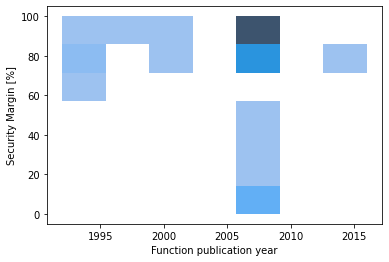

Block - year sec margin


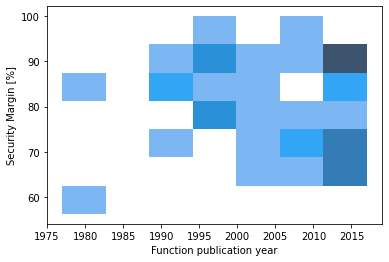

Block - year sec margin KEY


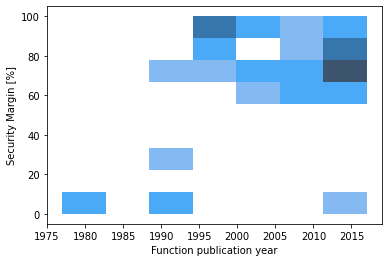

Block - year sec margin COMB


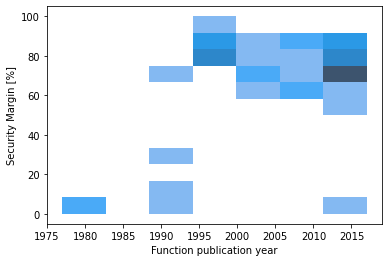

Stream - year sec margin


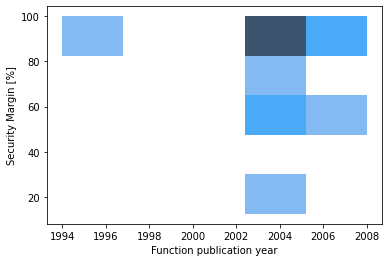

Stream - year sec margin KEY


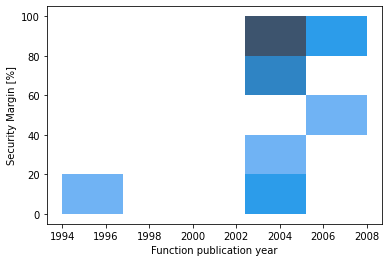

Stream - year sec margin COMB


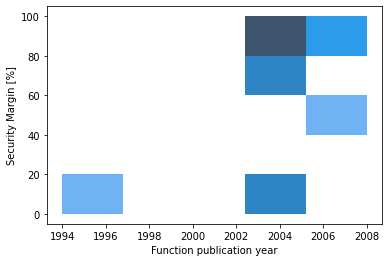

In [19]:
# Sec margin per category

def comp_sec_margin(maxr, brokenr):
    return 1 - (float(brokenr) / maxr)


margin_recs = []
for fname_x in stat_rej_meths_cons.keys():
    ftype, stype, fname = fname_x.split(":", 3)
    
    erec = FUNC_DB.search(fname, FuncInfo.HASH if ftype == 'H' else (FuncInfo.PRNG if ftype == 'P' else FuncInfo.CIPHER))
    if erec is None and finfo.fnc_type == 'prng':
        erec = FuncInfo(fname, FuncInfo.PRNG, 0, 1, 1)
    
    recs = stat_rej_meths_cons[fname_x]
    recs_inp = [x for x in recs if '.key' not in x[0]]
    recs_key = [x for x in recs if '.key' in x[0]]
    
    smargin_inp = comp_sec_margin(max(1, erec.max_rounds), recs_inp[0][1]) if recs_inp else 1
    smargin_key = comp_sec_margin(max(1, erec.max_rounds), recs_key[0][1]) if recs_key else 1
    margin_recs.append((fname_x, erec, recs_inp, recs_key, smargin_inp, smargin_key))

margin_recs.sort(key=lambda x: (x[1].ftype, x[1].stype, min(x[4], x[5]), x[1].fname))
for crec in itertools.islice(margin_recs, 500):
    erec = crec[1]
    has_key = erec.ftype != FuncInfo.HASH

    print(f'{"%40s" % crec[0]} [{"%4d" % (erec.year or 0)}] | {has_key} | {100*crec[4]} {100*crec[5]}')

hash_margins = [x for x in margin_recs if x[1].ftype == FuncInfo.HASH]
block_margins = [x for x in margin_recs if x[0].startswith('B:B:')]
stream_margins = [x for x in margin_recs if x[0].startswith('B:S:')]
mpc_margins = [x for x in margin_recs if x[0].startswith('B:M:')]

print(f'Hash sec margins avg: {"%.2f" % (100*np.mean([x[4] for x in hash_margins]))}, median: {"%.2f" % (100*np.median([x[4] for x in hash_margins]))}')
print(f'Block sec margins avg: {"%.2f" % (100*np.mean([x[4] for x in block_margins]))}, median: {"%.2f" % (100*np.median([x[4] for x in block_margins]))}; key:  {"%.2f" % (100*np.mean([x[5] for x in block_margins]))}, median: {"%.2f" % (100*np.median([x[5] for x in block_margins]))};')
print(f'Stream sec margins avg: {"%.2f" % (100*np.mean([x[4] for x in stream_margins]))}, median: {"%.2f" % (100*np.median([x[4] for x in stream_margins]))}; key: {"%.2f" % (100*np.mean([x[5] for x in stream_margins]))}, median: {"%.2f" % (100*np.median([x[5] for x in stream_margins]))}')
print(f'MPC sec margins avg: {"%.2f" % (100*np.mean([x[4] for x in mpc_margins]))}, median: {"%.2f" % (100*np.median([x[4] for x in mpc_margins]))}; key: {"%.2f" % (100*np.mean([x[5] for x in mpc_margins]))}, median: {"%.2f" % (100*np.median([x[5] for x in mpc_margins]))}')

print('Hash - year sec margin')
col_year = "Function publication year"
col_margin = "Security Margin [%]"
data_plot = pd.DataFrame({
    col_year: [x[1].year for x in hash_margins],
    col_margin: [100*x[4] for x in hash_margins],
})
plt.figure()#figsize=(16, 12))
sns.histplot(x = col_year, y=col_margin, data=data_plot)#, binwidth=0.005)
plt.show()

print('Block - year sec margin')
data_plot = pd.DataFrame({
    col_year: [x[1].year for x in block_margins],
    col_margin: [100*x[4] for x in block_margins],
})
plt.figure()#figsize=(16, 12))
sns.histplot(x = col_year, y=col_margin, data=data_plot)#, binwidth=0.005)
plt.show()

print('Block - year sec margin KEY')
data_plot = pd.DataFrame({
    col_year: [x[1].year for x in block_margins],
    col_margin: [100*x[5] for x in block_margins],
})
plt.figure()#figsize=(16, 12))
sns.histplot(x = col_year, y=col_margin, data=data_plot)#, binwidth=0.005)
plt.show()

print('Block - year sec margin COMB')
data_plot = pd.DataFrame({
    col_year: [x[1].year for x in block_margins],
    col_margin: [min(100*x[5], 100*x[4]) for x in block_margins],
})
plt.figure()#figsize=(16, 12))
sns.histplot(x = col_year, y=col_margin, data=data_plot)#, binwidth=0.005)
plt.show()

print('Stream - year sec margin')
data_plot = pd.DataFrame({
    col_year: [x[1].year for x in stream_margins],
    col_margin: [100*x[4] for x in stream_margins],
})
plt.figure()#figsize=(16, 12))
sns.histplot(x = col_year, y=col_margin, data=data_plot)#, binwidth=0.005)
plt.show()

print('Stream - year sec margin KEY')
data_plot = pd.DataFrame({
    col_year: [x[1].year for x in stream_margins],
    col_margin: [100*x[5] for x in stream_margins],
})
plt.figure()#figsize=(16, 12))
sns.histplot(x = col_year, y=col_margin, data=data_plot)#, binwidth=0.005)
plt.show()

print('Stream - year sec margin COMB')
data_plot = pd.DataFrame({
    col_year: [x[1].year for x in stream_margins],
    col_margin: [min(100*x[5], 100*x[4]) for x in stream_margins],
})
plt.figure()#figsize=(16, 12))
sns.histplot(x = col_year, y=col_margin, data=data_plot)#, binwidth=0.005)
plt.show()

In [20]:
xx=((sorted(list(funcres_agg.keys()))))
for x in xx:
    print(x)

AES
ARIA
ARIRANG
AURORA
Abacus
BLAKE
BLOWFISH
BMW
Blender
Boole
CAMELLIA
CAST
CHASKEY
CHI
Chacha
Cheetah
CubeHash
DCH
DECIM
DynamicSHA
DynamicSHA2
ECHO
ESSENCE
F-FCSR
FANTOMAS
Fubuki
GOST
Gost
Grain
Grostl
HC-128
HIGHT
Hamsi
Hermes
IDEA
JH
KASUMI
KUZNYECHIK
Keccak
LBLOCK
LEA
LED
LEX
Lesamnta
Luffa
MARS
MCSSHA3
MD5
MD6
MICKEY
MISTY1
NOEKEON
PICCOLO
PRIDE
PRINCE
Poseidon_S128_BLS12_138
Poseidon_S80b
RC4
RC5-20
RC6
RECTANGLE-K128
RECTANGLE-K80
RIPEMD160
ROAD-RUNNER-K128
ROAD-RUNNER-K80
ROBIN
ROBIN-STAR
Rabbit
RescueP_128a
RescueP_128b
RescueP_128c
RescueP_128d
RescueP_S80a
RescueP_S80b
RescueP_S80c
RescueP_S80d
Rescue_S128e
Rescue_S45a
SEED
SERPENT
SHA1
SHA2
SHA3
SHACAL2
SHAvite3
SIMD
SIMON
SINGLE-DES
SOSEMANUK
SPARX-B128
SPARX-B64
SPECK
Salsa20
Sarmal
Shabal
Skein
Starkad_S128e
Starkad_S80b
TEA
TIB3
TRIPLE-DES
TSC-4
TWINE
TWOFISH
Tangle
Tangle2
Tiger
Trivium
Twister
Vision_S128d
Vision_S45a
Whirlpool
XTEA
gmimc-S128e
gmimc-S45a
lowmc-s128a
lowmc-s128b
lowmc-s128c
lowmc-s128d
lowmc-s80a
l

In [168]:
smm.multipletests([0.1, 0.1], alpha=0.00001, method='hommel')

(array([False, False]), array([0.1, 0.1]), 5.00001250003379e-06, 5e-06)

In [34]:
rr=smm.multipletests([0.0059782697821275654, 0.008266275900149146, 0.002631935614658504]
, alpha=1.0/100_000, method='hommel') #method='holm')
print(rr)
print(sum(rr[0]))

(array([False, False, False]), array([0.00826628, 0.00826628, 0.00789581]), 3.333344444467201e-06, 3.3333333333333337e-06)
0


In [ ]:
aa= [0.9121828654785112, 0.833330367706585, 0.7093639039276031, 0.9959007025176326, 9.99999999999999e-06, 0.635059882346217, 0.8783878200536325, 0.9798642402105848, 0.5222091596748696, 0.15071023186714566, 0.4693315769509818, 0.07120851273036127, 0.01226056809312033, 9.99999999999999e-06, 0.2740538974955782, 0.1408866600020051, 0.15990129135702902, 0.022208832525639224, 0.620462164574861, 0.5810493639005612, 0.22082143925911576, 0.9431710606681458, 0.10132789920931946, 0.8399921566292053, 0.7573313680270666, 0.8582832940218369, 0.17447994920151297, 0.5084652750238541, 0.15133432047685766, 0.34007336095693813, 0.10923647188790106, 9.99999999999999e-06, 0.8668662641181974, 0.3915499565416737, 0.38122795346486554, 0.30263628949357846]
rr=smm.multipletests(aa, alpha=1.0/100_000, method='hommel') #method='holm')
print(rr)
print(sum(rr[0]))